# Colorado Canopy Height Change Analysis  
*(Niwot Ridge · West St. Louis Creek · North Sterling · Rocky Mountain NP · Central Plains Experimental Range · Arikaree River)*  

This notebook tracks multi-year canopy-height change across **six** NEON field sites that span alpine peaks, mountain forests, prairies, croplands, and riparian grasslands.

| Site (code) | Setting | Elev. (m) | Area (km²) | Key Research Focus|
|-------------|---------|-----------|------------|----------------|
| **Niwot Ridge Mountain Research Station (NIWO)** ¹ | Alpine & sub-alpine forest | 2,900 | 13.4 | High-elevation benchmark for climate-sensitive canopy change. |
| **West St. Louis Creek (WLOU)** ² | Snow-fed mountain stream | 2,902 | 4.9 | Riparian–snowmelt coupling in cold headwaters. |
| **North Sterling (STER)** ³ | Semi-arid cropland | 1,350 | 3.2 | Long-term no-till wheat rotation—carbon & water-flux contrasts. |
| **Rocky Mountain National Park (RMNP)** ⁴ | Mid-elevation mountain forest | 2,750 | 46.5 | Dust/pollution deposition and disturbance gradients. |
| **Central Plains Experimental Range (CPER)** ⁵ | Short-grass prairie | 1,600 | 65.4 | Grazing & drought impacts on open-range vegetation. |
| **Arikaree River (ARIK)** ⁶ | Tall-grass riparian prairie | 1,300 | 2,631.8 | Free-flowing prairie stream—disturbance & invasion sensitivity. |

---

## What Is the NEON Canopy Height Model (CHM)?  
* **Product:** *Ecosystem Structure* (DP3.30015.001)  
* **Resolution:** 1 m, delivered in 1 km × 1 km GeoTIFF tiles  
* **Acquisition:** Full-waveform LiDAR flown annually (≥ 4 pulses m⁻², 37 % overlap)  
* **Processing:** **Pit-free algorithm** minimizes crown-height underestimation; QA/QC reports accompany each flight  
* **Use here:** Year-to-year CHM differencing (e.g., 2017 → 2023) maps growth, loss & stability.  
*See full metadata & citation guidance:* <https://data.neonscience.org/data-products/DP3.30015.001>

---

## Key Questions  
1. **Canopy Change:** Where are gains, losses, and stable areas?  
2. **Biome Patterns:** How do drivers differ among alpine, prairie, cropland, and riparian systems?  
3. **Prediction:** Can a Random Forest model reliably label change zones?

## Workflow Snapshot  
1. **Load & Align** CHMs for each site/year  
2. **Explore** histograms, maps, summary stats  
3. **Model** growth / loss / stable classes with Random Forest  

---

### References  
1. Niwot Ridge – <https://www.neonscience.org/field-sites/niwo>  
2. West St. Louis Creek – <https://www.neonscience.org/field-sites/wlou>  
3. North Sterling – <https://www.neonscience.org/field-sites/ster>  
4. Rocky Mountain NP – <https://www.neonscience.org/field-sites/rmnp>  
5. Central Plains Experimental Range – <https://www.neonscience.org/field-sites/cper>  
6. Arikaree River – <https://www.neonscience.org/field-sites/arik>

## Step 1: Querying NEON for CHM Data

This section demonstrates how data and metadata are retrieved from NEON’s public API for the Canopy Height Model (CHM) data product (DP3.30015.001) at the 6 Colorado sites. A query URL is constructed based on the selected site, product code, and date range (2013–2023). A request is sent to the API, and the response is parsed to collect relevant file information. The output is a CSV catalog of available GeoTIFF files, including filename, year, month, and download URLs, which can be used for subsequent data downloads and analysis.

In [2]:
# import libraries
import os
import requests
import pandas as pd
import numpy as np
import glob
import rasterio
from collections import defaultdict
from tqdm import tqdm

In [26]:
# Multiple site codes
site_codes = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]

product_code = "DP3.30015.001"
start_date = "2013-01"
end_date = "2023-12"

# Base folder to store outputs
base_folder_path = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"
os.makedirs(base_folder_path, exist_ok=True)  # Ensure the base directory exists

for site_code in site_codes:
    print(f"Querying site: {site_code}")
    query_url = (
        f"https://data.neonscience.org/api/v0/data/query?"
        f"productCode={product_code}&"
        f"siteCode={site_code}&"
        f"startDateMonth={start_date}&"
        f"endDateMonth={end_date}"
    )

    response = requests.get(query_url)
    if response.status_code != 200:
        raise Exception(f"Failed to query NEON API for site {site_code}: {response.status_code}")

    results = response.json()

    # Collect metadata for this site
    metadata = []
    releases = results.get("data", {}).get("releases", [])
    seen = set()  # to avoid duplicates

    for release in releases:
        for package in release.get("packages", []):
            month_tag = package.get("month", "Unknown")
            if "-" in month_tag:
                year_str, month_str = month_tag.split("-")
            else:
                year_str, month_str = "Unknown", "Unknown"

            for file in package.get("files", []):
                name = file.get("name", "")
                url = file.get("url", "")

                # Only include GeoTIFF files, ignoring duplicates
                if name.endswith(".tif") and year_str.isdigit() and month_str.isdigit():
                    key = (name, year_str)
                    if key in seen:
                        continue
                    seen.add(key)

                    metadata.append({
                        "filename": name,
                        "year": int(year_str),
                        "month": int(month_str),
                        "url": url
                    })

    # Convert to DataFrame
    metadata_df = pd.DataFrame(metadata)
    # Sort by year, month, then filename
    metadata_df = metadata_df.sort_values(
        by=["year", "month", "filename"],
        ascending=[True, True, True]
    )

    # Create the site-specific subfolder
    site_folder_path = os.path.join(base_folder_path, site_code)
    os.makedirs(site_folder_path, exist_ok=True)

    # Save CSV in the site-specific folder
    csv_filename = f"{site_code}_chm_file_catalog.csv"
    csv_path = os.path.join(site_folder_path, csv_filename)
    metadata_df.to_csv(csv_path, index=False)

    print(f"✅ Saved {csv_path}")

Querying site: NIWO
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\NIWO\NIWO_chm_file_catalog.csv
Querying site: WLOU
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\WLOU\WLOU_chm_file_catalog.csv
Querying site: STER
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\STER\STER_chm_file_catalog.csv
Querying site: RMNP
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\RMNP\RMNP_chm_file_catalog.csv
Querying site: CPER
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\CPER\CPER_chm_file_catalog.csv
Querying site: ARIK
✅ Saved C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\ARIK\ARIK_chm_file_catalog.csv


## Step 2: Downloading CHM TIFF Files

In this section, the CSV catalog generated previously is used to download Canopy Height Model (CHM) GeoTIFFs from NEON’s data portal. Each file is saved into a subfolder corresponding to its data year. The process checks whether a local copy exists before making a request, which avoids redundant downloads. A simple summary shows how many files were successfully retrieved for each year.

In [29]:
# Base directory containing site folders and their respective CSV catalogs
base_dir = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"

# List of site codes
site_codes = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]

for site_code in site_codes:
    print(f"\nProcessing site: {site_code}")

    # Path to the site-specific CSV
    catalog_path = os.path.join(base_dir, site_code, f"{site_code}_chm_file_catalog.csv")
    
    # If the CSV doesn't exist, skip
    if not os.path.exists(catalog_path):
        print(f"❌ Catalog not found for {site_code}: {catalog_path}")
        continue

    # Read the CSV
    catalog_df = pd.read_csv(catalog_path)
    
    # Dictionary to keep track of how many files we download per year
    download_counts = defaultdict(int)

    # Use tqdm to create a progress bar for iterating over the DataFrame rows
    # 'total=len(catalog_df)' so tqdm knows how many iterations to expect
    for _, row in tqdm(
        catalog_df.iterrows(),
        total=catalog_df.shape[0],
        desc=f"Downloading from site {site_code}"
    ):
        year = str(row["year"])
        filename = row["filename"]
        url = row["url"]

        # Directory structure: base_dir / site_code / year
        year_dir = os.path.join(base_dir, site_code, year)
        os.makedirs(year_dir, exist_ok=True)

        # Full path for this GeoTIFF
        save_path = os.path.join(year_dir, filename)

        # Only download if we don't already have the file
        if not os.path.exists(save_path):
            try:
                r = requests.get(url, stream=True)
                r.raise_for_status()
                with open(save_path, "wb") as f:
                    # Show a chunk-level progress bar by wrapping chunk iteration
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
                download_counts[year] += 1
            except Exception as e:
                print(f"❌ Failed to download {filename} for {site_code}: {e}")

    # Print summary for this site
    print(f"\n✅ Download Summary for {site_code}:")
    if download_counts:
        for y, count in sorted(download_counts.items()):
            print(f"  Year {y}: {count} file(s) downloaded")
    else:
        print("  All files already present; no downloads were needed.")


Processing site: NIWO



✅ Download Summary for NIWO:
  Year 2017: 204 file(s) downloaded
  Year 2018: 171 file(s) downloaded
  Year 2019: 172 file(s) downloaded
  Year 2020: 165 file(s) downloaded
  Year 2023: 171 file(s) downloaded

Processing site: WLOU



✅ Download Summary for WLOU:
  Year 2017: 54 file(s) downloaded
  Year 2019: 38 file(s) downloaded
  Year 2020: 40 file(s) downloaded
  Year 2023: 42 file(s) downloaded

Processing site: STER



✅ Download Summary for STER:
  Year 2013: 77 file(s) downloaded
  Year 2017: 186 file(s) downloaded
  Year 2021: 139 file(s) downloaded
  Year 2022: 141 file(s) downloaded

Processing site: RMNP



✅ Download Summary for RMNP:
  Year 2017: 233 file(s) downloaded
  Year 2018: 210 file(s) downloaded
  Year 2020: 214 file(s) downloaded
  Year 2022: 217 file(s) downloaded
  Year 2023: 215 file(s) downloaded

Processing site: CPER



✅ Download Summary for CPER:
  Year 2013: 119 file(s) downloaded
  Year 2017: 121 file(s) downloaded
  Year 2020: 232 file(s) downloaded
  Year 2021: 143 file(s) downloaded

Processing site: ARIK



✅ Download Summary for ARIK:
  Year 2017: 225 file(s) downloaded
  Year 2020: 253 file(s) downloaded
  Year 2021: 252 file(s) downloaded
  Year 2023: 255 file(s) downloaded


## Step 3: CHM Raster Inspection and Summary Statistics

This section examines each Canopy Height Model (CHM) GeoTIFF to verify data integrity and gather basic statistics. The code traverses all year-specific subfolders, loads each CHM tile, and computes:

- **Raster Dimensions** (width, height, total number of pixels)
- **Valid Pixel Counts** (total pixels minus those assigned as no-data)
- **No-Data Statistics** (count of no-data pixels, percentage of valid area)
- **Height Metrics** (minimum, maximum, mean, standard deviation)

By calculating these values, potential issues such as incomplete tiles or suspicious canopy heights (e.g., negative or extremely large values) can be quickly identified. For instance, a tile with a high fraction of no-data pixels might indicate partial coverage or flight limitations. These summary tables also help confirm that multiple years’ data are consistent in resolution, spatial extent, and coordinate reference system (CRS) before proceeding with change detection or modeling. The resulting CSV file facilitates easy filtering and comparisons across all tiles and years.

In [44]:
# Load a single 2017 NIWO CHM tile and print its rasterio metadata
tif_path = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NIWO/2017/NEON_D13_NIWO_DP3_443000_4428000_CHM.tif"
with rasterio.open(tif_path) as src:
    meta = src.meta     # Dictionary with driver, width, height, CRS, dtype, etc.
    print("Meta (Dictionary):", meta)

Meta (Dictionary): {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]'), 'transform': Affine(1.0, 0.0, 443000.0,
       0.0, -1.0, 4429000.0)}


### CHM Tile Metadata

| Field | Description | Relevance for Analysis |
|-------|-------------|------------------------|
| **driver** (`GTiff`) | File format is GeoTIFF. | Readable by rasterio and GIS tools. |
| **dtype** (`float32`) | 32-bit floating-point pixel values. | Keeps decimal canopy heights; be mindful of RAM. |
| **nodata** (`-9999.0`) | Value marking missing data. | Mask these cells to avoid skewing stats or ML models. |
| **width / height** (`1000 × 1000`) | Pixel dimensions of the tile. | Combined with 1 m resolution → a 1 km² tile. |
| **count** (`1`) | Number of raster bands. | Single-band image—no band selection needed. |
| **crs** (`EPSG:32613`, UTM 13N) | Projected coordinate system in meters. | Guarantees alignment when stacking or differencing CHMs. |
| **transform** (`Affine(1, 0, 443000; 0, -1, 4429000)`) | Origin and pixel size (1 m). | Converts between pixel indices and real-world easting/northing. |

In [7]:
# Directory containing site folders
master_dir = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"

# List of site codes (folders)
site_codes = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]

summary_records = []

# Loop over each site
for site_code in site_codes:
    # Full path to the folder for this site
    site_folder = os.path.join(master_dir, site_code)
    if not os.path.isdir(site_folder):
        print(f"❌ Site folder not found: {site_folder}")
        continue

    # Gather all subfolders under this site
    year_folders = sorted(
        d for d in glob.glob(os.path.join(site_folder, "*")) if os.path.isdir(d)
    )

    for year_folder in year_folders:
        year = os.path.basename(year_folder)
        # Find all .tif files in that year folder
        all_tifs = glob.glob(os.path.join(year_folder, "*.tif"))

        # Show progress bar for each site-year combination
        for tif_path in tqdm(all_tifs, desc=f"Analyzing {site_code}/{year}"):
            with rasterio.open(tif_path) as src:
                meta = src.meta
                data = src.read(1)

                # Total pixel count
                total_pixels = meta["width"] * meta["height"]

                # NoData handling
                nodata_val = meta.get("nodata", -9999)
                data_masked = np.ma.masked_equal(data, nodata_val)
                valid_pixels = data_masked.count()
                nodata_pixels = total_pixels - valid_pixels
                valid_fraction = valid_pixels / total_pixels if total_pixels > 0 else 0
                valid_percent = valid_fraction * 100

                # Basic stats on the masked data
                min_val = data_masked.min()
                max_val = data_masked.max()
                mean_val = data_masked.mean()
                std_val = data_masked.std()

                # Append a record for this file
                summary_records.append({
                    "site_code": site_code,
                    "year": year,
                    "filename": os.path.basename(tif_path),
                    "driver": meta["driver"],
                    "dtype": meta["dtype"],
                    "nodata_value": nodata_val,
                    "width": meta["width"],
                    "height": meta["height"],
                    "count_bands": meta["count"],
                    "crs": str(meta["crs"]),
                    "transform": str(meta["transform"]),
                    "total_pixels": total_pixels,
                    "valid_pixels": valid_pixels,
                    "nodata_pixels": nodata_pixels,
                    "pct_valid_pixels": valid_percent,
                    "min_height": min_val,
                    "max_height": max_val,
                    "mean_height": mean_val,
                    "std_height": std_val
                })

# Convert the records to a DataFrame
summary_df = pd.DataFrame(summary_records)

# Sort by site_code -> year -> filename
summary_df = summary_df.sort_values(["site_code", "year", "filename"])

# Save to a CSV in your master folder
output_csv = os.path.join(master_dir, "ALL_sites_CHM_summary_stats.csv")
summary_df.to_csv(output_csv, index=False)

print("✅ Summary statistics saved to:", output_csv)

Analyzing ARIK/2023: 100%|██████████| 255/255 [00:06<00:00, 38.37it/s]


✅ Summary statistics saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\ALL_sites_CHM_summary_stats.csv


In [8]:
# Display summary df
summary_df.head()

,site_code,year,filename,driver,dtype,nodata_value,width,height,count_bands,crs,transform,total_pixels,valid_pixels,nodata_pixels,pct_valid_pixels,min_height,max_height,mean_height,std_height
3304,ARIK,2017,NEON_D10_ARIK_DP3_705000_4394000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 705000.00|\n| 0.00,-1.00, 439500...",1000000,91008,908992,9.1008,0.0,4.88,0.000966,0.063693
3305,ARIK,2017,NEON_D10_ARIK_DP3_705000_4395000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 705000.00|\n| 0.00,-1.00, 439600...",1000000,282485,717515,28.2485,0.0,8.27,0.010571,0.226055
3306,ARIK,2017,NEON_D10_ARIK_DP3_705000_4396000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 705000.00|\n| 0.00,-1.00, 439700...",1000000,263716,736284,26.3716,0.0,0.00,0.000000,0.000000
3307,ARIK,2017,NEON_D10_ARIK_DP3_705000_4397000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 705000.00|\n| 0.00,-1.00, 439800...",1000000,332504,667496,33.2504,0.0,0.00,0.000000,0.000000
3308,ARIK,2017,NEON_D10_ARIK_DP3_705000_4398000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 705000.00|\n| 0.00,-1.00, 439900...",1000000,348929,651071,34.8929,0.0,15.50,0.018033,0.374329


In [9]:
# 1) Proportion of nodata pixels
nodata_stats = (
    summary_df.groupby(["site_code", "year"])["pct_valid_pixels"]
    .agg(["min", "mean", "max"])
    .rename(columns={"min": "min % valid", "mean": "avg % valid", "max": "max % valid"})
    .sort_values("site_code")
)
print("\nNodata coverage (% valid pixels) by site and year:\n")
print(nodata_stats)
print("\n" + "="*50 + "\n")

# 2) Group by site_code to see average canopy height across all years
print("Average canopy height by site (averaging mean_height across all TIFs at each site):\n")
avg_by_site = summary_df.groupby("site_code")["mean_height"].mean()
print(avg_by_site)
print("\n" + "="*50 + "\n")

# 3) Group by site_code and year for more granular stats
print("Summary of mean_height by site_code & year:\n")
site_year_stats = summary_df.groupby(["site_code", "year"])["mean_height"].agg(["count", "mean", "min", "max", "std"])
print(site_year_stats)
print("\n" + "="*50 + "\n")


# 4) Coefficient of variation (CV) — measures canopy-height heterogeneity
summary_df["cv_height"] = summary_df["std_height"] / summary_df["mean_height"]
cv_table = (
    summary_df.groupby(["site_code", "year"])["cv_height"]
    .mean()
    .unstack("site_code")
    .round(3)
)
print("\nCoefficient of variation of height (mean of tiles):\n")
print(cv_table)
print("\n" + "="*50 + "\n")


# 3) Outlier scan — any tile with suspect values (<0 m or >100 m)
suspect_tiles = summary_df[
    (summary_df["min_height"] < 0) | (summary_df["max_height"] > 100)
][
    ["site_code", "year", "filename", "min_height", "max_height"]
]
print("\nTiles with height outside expected 0–100 m range:\n")
print(suspect_tiles if not suspect_tiles.empty else "None found.")
print("\n" + "="*50 + "\n")


# 4) Year-over-year change in average canopy height (Δmean)
yearly_mean = (
    summary_df.groupby(["site_code", "year"])["mean_height"]
    .mean()
    .unstack("year")
    .sort_index(axis=1)          # chronological columns
)
delta_table = yearly_mean.diff(axis=1).iloc[:, 1:]   # first diff skips earliest year
print("\nYear-over-year Δmean canopy height (m):\n")
print(delta_table.round(2))


Nodata coverage (% valid pixels) by site and year:

                min % valid  avg % valid  max % valid
site_code year                                       
ARIK      2017       9.1008    88.304076        100.0
          2020       1.3794    86.194880        100.0
          2021       2.7860    86.566833        100.0
          2023       0.0304    85.286964        100.0
CPER      2013       0.2486    81.519569        100.0
          2017      24.5534    84.816212        100.0
          2020       3.9820    76.836822        100.0
          2021       5.0897    81.381029        100.0
NIWO      2020       0.7255    80.752905        100.0
          2019       0.0050    86.128994        100.0
          2023       0.0004    87.112870        100.0
          2017       0.0111    81.114601        100.0
          2018       0.0385    86.731901        100.0
RMNP      2017       0.0142    85.643386        100.0
          2018       2.0846    92.600039        100.0
          2020       0.1132  

### Summary of CHM Raster Statistics

#### Nodata Coverage
- Most sites show valid pixel coverage above 80 % across all years.
- WLOU has the lowest valid coverage (~ 60–70 %), while CPER (2020) and ARIK (2023) show moderate reductions (~ 76–85 %).
- RMNP consistently maintains over 90 % valid pixel coverage.

#### Mean Canopy Heights
- NIWO, RMNP, and WLOU have average mean heights between 4–6 m across all years.
- ARIK, CPER, and STER have very low mean canopy heights, generally below 0.2 m.

#### Coefficient of Variation (CV)
- ARIK and CPER show high CV values (>100 %) in some years, indicating a large relative spread between minimum and maximum canopy heights.
- Forested sites (NIWO, RMNP, WLOU) have lower CVs, typically between 0.8 and 1.7.

#### Height Range Outliers
- A small number of tiles (~8) recorded maximum canopy heights slightly above 100 m (up to 101.5 m).
- No negative canopy height values were detected.

#### Year-over-Year Changes in Mean Height
- NIWO and RMNP show positive changes in mean canopy height between 2017–2018 (+0.9 m and +1.28 m, respectively).
- WLOU shows a negative change (-2.57 m) between 2019–2020.
- Prairie and cropland sites (ARIK, CPER, STER) show minimal year-over-year change (<0.05 m).

### CHM Summary Statistics – Visual Exploration

This section generates plots to visualize canopy height and data quality patterns across sites and years, based on the compiled summary statistics:

- **Bar Plot:** Average canopy height by site across all available years.
- **Box Plot:** Distribution of mean canopy heights by site, highlighting variability across tiles.
- **Histogram:** Overall distribution of mean heights across all sites and years.
- **Time Series Plot:** Mean canopy height through time, grouped by site.
- **Bar Plot (Valid Pixels):** Average percentage of valid pixels by site.
- **Bar Plot (Height Variability):** Average coefficient of variation (CV) of canopy heights by site.
- **Scatter Plot:** Relationship between mean canopy height and percentage of valid pixels.
- **Box Plot (Valid Pixels):** Distribution of percentage of valid pixels by site.

These visualizations provide an early-stage check for consistency, variability, data completeness, and potential anomalies in canopy structure across sites and years.
No biological or disturbance interpretations are made at this stage.

#### Bar Plot of Average Canopy Height

For all sites across all available years

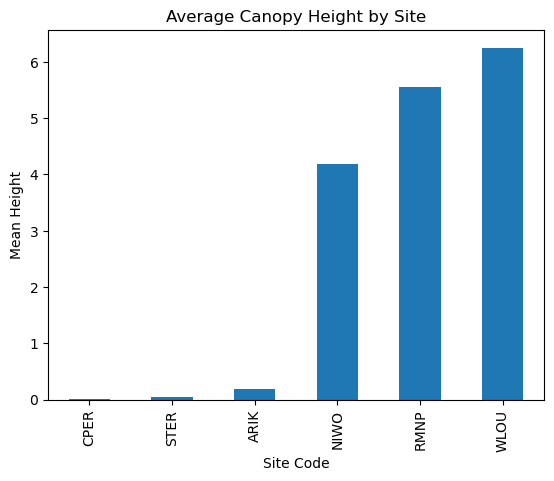

In [10]:
import matplotlib.pyplot as plt

# Compute average mean_height by site
avg_by_site = summary_df.groupby("site_code")["mean_height"].mean()

# Sort the values in ascending order
avg_by_site = avg_by_site.sort_values(ascending=True)

plt.figure()
avg_by_site.plot(kind="bar")
plt.title("Average Canopy Height by Site")
plt.xlabel("Site Code")
plt.ylabel("Mean Height")
plt.show()

#### Box Plot of Distribution of Mean Canopy Heights 

Highlighting variability across tiles.

<Figure size 640x480 with 0 Axes>

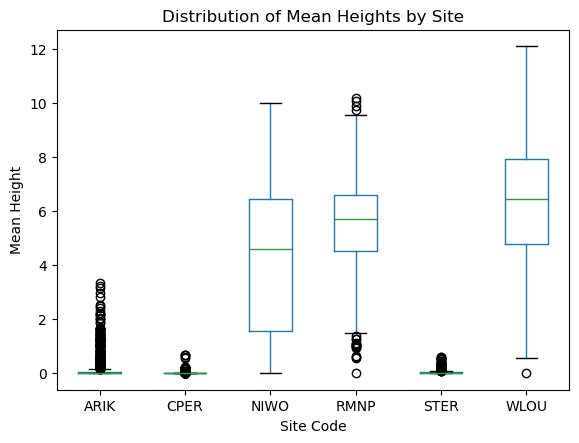

In [100]:
plt.figure()

# Draw a boxplot per site_code, showing distribution of "mean_height"
summary_df.boxplot(column="mean_height", by="site_code", grid=False)

# Adjust chart titles
plt.title("Distribution of Mean Heights by Site")
plt.suptitle("")  # remove the default Pandas boxplot title
plt.xlabel("Site Code")
plt.ylabel("Mean Height")
plt.show()

#### Histogram of Distribution of Mean Canopy Heights

Overall distribution of mean heights across all sites and years

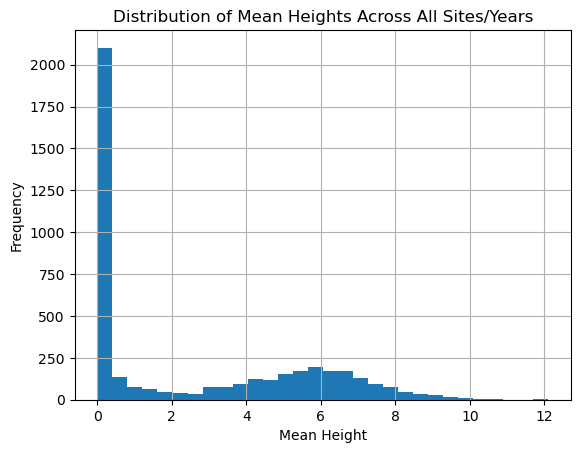

In [102]:
plt.figure()
summary_df["mean_height"].hist(bins=30)  # Adjust bins as needed
plt.title("Distribution of Mean Heights Across All Sites/Years")
plt.xlabel("Mean Height")
plt.ylabel("Frequency")
plt.show()

#### Time Series Plot

Mean canopy height through time, grouped by site

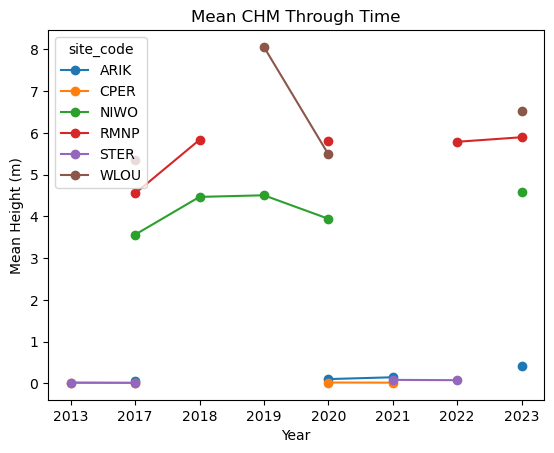

In [104]:
# yearly mean per site
ts = (summary_df
      .groupby(["site_code","year"])["mean_height"]
      .mean()
      .unstack("site_code")             # rows=year, cols=site
      .sort_index())                    # ascending years

ts.plot(marker="o")
plt.title("Mean CHM Through Time")
plt.xlabel("Year"); plt.ylabel("Mean Height (m)")
plt.show()

#### Bar Plot of Valid Pixles

Average percentage of valid pixel by site

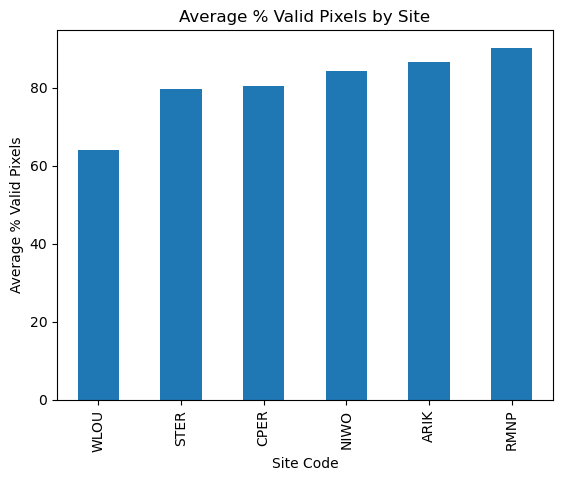

In [106]:
valid_pct_by_site = summary_df.groupby("site_code")["pct_valid_pixels"].mean()

plt.figure()
valid_pct_by_site.sort_values().plot(kind="bar")
plt.title("Average % Valid Pixels by Site")
plt.xlabel("Site Code")
plt.ylabel("Average % Valid Pixels")
plt.show()

#### Scatter Plot of Mean Canopy Height and % Valid Pixels

Tiles with very low % valid values (< 50 %) could be candidates

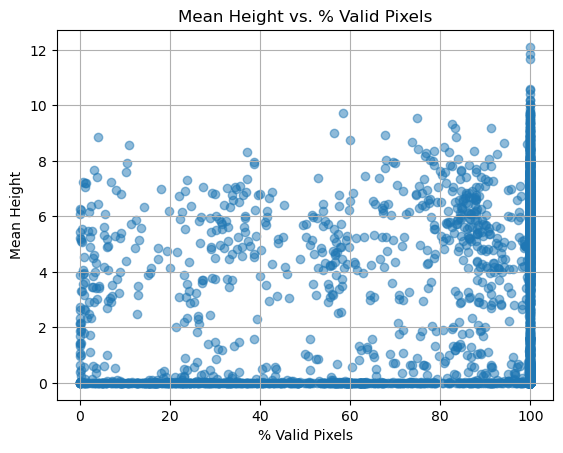

In [112]:
plt.figure()
plt.scatter(summary_df["pct_valid_pixels"], summary_df["mean_height"], alpha=0.5)
plt.title("Mean Height vs. % Valid Pixels")
plt.xlabel("% Valid Pixels")
plt.ylabel("Mean Height")
plt.grid(True)
plt.show()

#### Box Plot of Distribution of % Valid Pixels by Site

Overall, while most tiles across sites meet good data coverage standards, certain sites (especially WLOU) exhibit more frequent partial tile coverage that may require masking or filtering before analysis.

<Figure size 640x480 with 0 Axes>

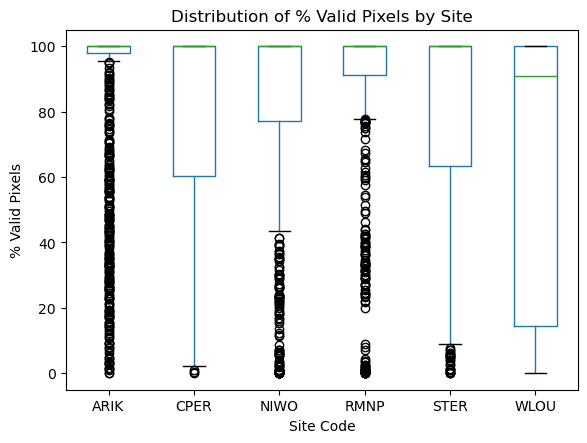

In [110]:
plt.figure()
summary_df.boxplot(column="pct_valid_pixels", by="site_code", grid=False)
plt.title("Distribution of % Valid Pixels by Site")
plt.suptitle("")
plt.xlabel("Site Code")
plt.ylabel("% Valid Pixels")
plt.show()

## Step 4: Create Yearly Mosaics for Each NEON Site

The script below converts the many 1 km² CHM tiles in every **site / year** folder into a single mosaic for that site-year:

1. **Year folders discovered automatically**  
   Any 4-digit folder names (e.g., 2013 … 2023) inside each site directory are treated as years that contain CHM tiles.

2. **Tiles gathered**  
   All `.tif` files in `<site>/<year>/` are listed.

3. **Tiles merged**  
   `rasterio.merge.merge()` stitches the tiles into one array.  
   (All tiles are assumed to share CRS, resolution and NoData.)

4. **Metadata updated & mosaic written**  
   Dimensions, transform, and compression (`LZW`) are copied / updated, and the result is saved as  
   `mosaics/<SITE>/<SITE>_CHM_<YEAR>.tif`.

The outcome is **one GeoTIFF per site-year**, which greatly simplifies later alignment, difference-map creation and statistical analysis.

In [143]:
from rasterio.merge import merge

# 1) Define base directory containing all site folders
base_dir = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"

# 2) List of site codes (folder names)
site_codes = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]

# 3) Create a top-level "mosaics" folder to store final outputs
mosaic_root = os.path.join(base_dir, "mosaics")
os.makedirs(mosaic_root, exist_ok=True)

for site_code in site_codes:
    site_folder = os.path.join(base_dir, site_code)
    if not os.path.isdir(site_folder):
        print(f"⚠️  Site folder not found for {site_code}, skipping...")
        continue

    # 4) Create a site-specific subfolder in "mosaics"
    site_mosaic_dir = os.path.join(mosaic_root, site_code)
    os.makedirs(site_mosaic_dir, exist_ok=True)

    # 5) Find all subfolders that look like year names
    year_folders = [
        d for d in os.listdir(site_folder)
        if os.path.isdir(os.path.join(site_folder, d)) and d.isdigit()
    ]

    for year in sorted(year_folders):
        year_folder = os.path.join(site_folder, year)

        # Gather all .tif files within this year folder
        tif_files = [
            os.path.join(year_folder, f)
            for f in os.listdir(year_folder)
            if f.endswith(".tif")
        ]

        if not tif_files:
            print(f"⚠️ No TIFFs found for {site_code} {year}, skipping...")
            continue

        print(f"🛠 Creating mosaic for {site_code} {year} with {len(tif_files)} files...")

        # Open all TIFFs
        src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]

        # Merge them in-memory
        mosaic, out_trans = merge(src_files_to_mosaic)

        # Copy metadata from first file
        out_meta = src_files_to_mosaic[0].meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "compress": "lzw"
        })

        # Construct output filename
        mosaic_filename = f"{site_code}_CHM_{year}.tif"
        output_fp = os.path.join(site_mosaic_dir, mosaic_filename)

        # Write the mosaic to disk
        with rasterio.open(output_fp, "w", **out_meta) as dest:
            dest.write(mosaic)

        # Close sources
        for src in src_files_to_mosaic:
            src.close()

        print(f"✅ Mosaic for {site_code} {year} saved to: {output_fp}")

🛠 Creating mosaic for NIWO 2017 with 204 files...
✅ Mosaic for NIWO 2017 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2017.tif
🛠 Creating mosaic for NIWO 2018 with 171 files...
✅ Mosaic for NIWO 2018 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2018.tif
🛠 Creating mosaic for NIWO 2019 with 172 files...
✅ Mosaic for NIWO 2019 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2019.tif
🛠 Creating mosaic for NIWO 2020 with 165 files...
✅ Mosaic for NIWO 2020 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2020.tif
🛠 Creating mosaic for NIWO 2023 with 171 files...
✅ Mosaic for NIWO 2023 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2023.tif
🛠 Creating mosaic for WLOU 2017 with 54 files...
✅ Mosaic for WLOU 2017 saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS

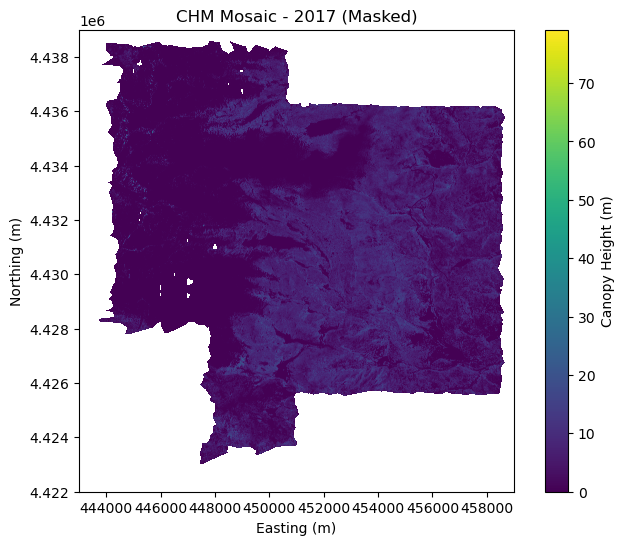

In [11]:
from rasterio.plot import plotting_extent

mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2017.tif"

with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)
    extent = plotting_extent(src)

# Replace -9999 with np.nan so that matplotlib ignores them
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

plt.figure(figsize=(8, 6))
plt.title("CHM Mosaic - 2017 (Masked)")

# Now the nodata pixels are NaN, so they won't affect the color range
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")

cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

In [12]:
# Flatten the mosaic data into a 1D array
all_values = chm_data.flatten()
total_pixels = all_values.size

# Count nodata pixels (value -9999)
nodata_count = np.sum(all_values == -9999)

# Compute valid pixels and their percentage
valid_count = total_pixels - nodata_count
valid_percentage = (valid_count / total_pixels) * 100

print(f"Total pixels: {total_pixels}")
print(f"Number of nodata pixels: {nodata_count}")
print(f"Number of valid pixels: {valid_count}")
print(f"Percentage of valid pixels: {valid_percentage:.2f}%")

# Replace -9999 with np.nan to exclude them from min/max
valid_values = np.where(all_values == -9999, np.nan, all_values)
print("Valid min:", np.nanmin(valid_values))
print("Valid max:", np.nanmax(valid_values))
print("Mean canopy height:", np.nanmean(valid_values))

Total pixels: 272000000
Number of nodata pixels: 0
Number of valid pixels: 272000000
Percentage of valid pixels: 100.00%
Valid min: 0.0
Valid max: 79.133
Mean canopy height: 3.6455364


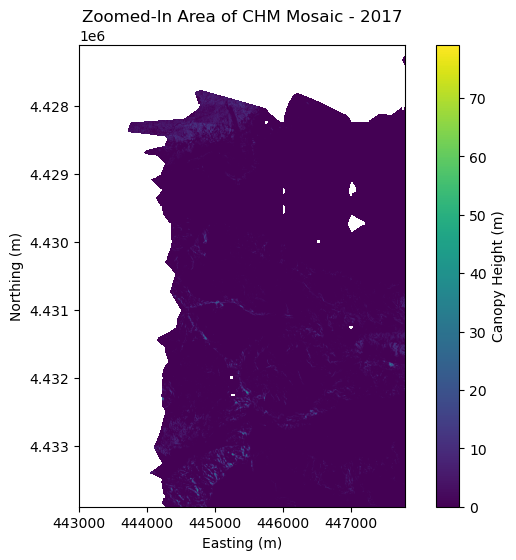

In [17]:
# Load the mosaic
mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2017.tif"
with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)  # Read the first band
    extent = plotting_extent(src)  # Get the spatial extent

# Mask out nodata values (-9999) by replacing them with np.nan
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

# Define the full extent: [left, right, bottom, top]
left, right, bottom, top = extent

# Example zoom: focus on the western 30% of the mosaic
zoom_left = left
zoom_right = left + 0.3 * (right - left)
# For the vertical range, choose a sub-region; adjust these values as needed
zoom_bottom = bottom + 0.3 * (top - bottom)
zoom_top = bottom + 0.7* (top - bottom)

plt.figure(figsize=(8, 6))
plt.title("Zoomed-In Area of CHM Mosaic - 2017")

# Plot the full mosaic
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")
# Adjust the plot limits to zoom into the selected area
plt.xlim(zoom_left, zoom_right)
plt.ylim(zoom_top, zoom_bottom)  # Note: origin='upper' means y-values decrease upward

# Add a colorbar to interpret the canopy height values
cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

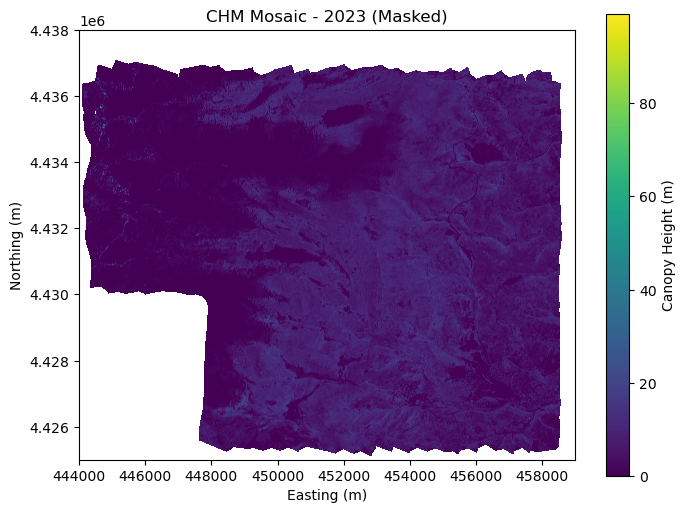

In [16]:
# Load the mosaic
mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\mosaics\NIWO\NIWO_CHM_2023.tif"

with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)
    extent = plotting_extent(src)

# Replace -9999 with np.nan so that matplotlib ignores them
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

plt.figure(figsize=(8, 6))
plt.title("CHM Mosaic - 2023 (Masked)")

# Now the nodata pixels are NaN, so they won't affect the color range
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")

cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

**Note on the Masked CHM Mosaic Plot**

- **Nodata Masking**: By converting `-9999` values to `NaN`, nodata pixels are excluded from the color scale. 
- **Coordinate Axes**: 
  - **Easting (m)** represents the horizontal axis in meters within the UTM coordinate system.  
  - **Northing (m)** is the vertical axis, also in meters under UTM. 
  Together, they define the georeferenced location of each pixel.
- **Overall Appearance**: Areas with visible patterns indicate regions of varying vegetation height, while any fully transparent or white areas (if present) represent masked nodata pixels. 

## Step 5: Align Yearly Mosaics to a Common Reference Grid (and Build Difference Maps)

For every site we:

1. **Select the reference year automatically**  
   *The script sorts each site’s mosaics by year and picks the **earliest‐available mosaic** (e.g., 2013 for CPER, 2017 for NIWO, etc.) as that site’s reference grid.*

2. **Align all other yearly mosaics to that grid**  
   *• If a mosaic already has the same CRS, transform, width and height as the reference, it is simply copied.*  
   *• Otherwise it is reprojected/resampled to the reference grid (bilinear resampling) while preserving NoData.*

3. **Write the aligned files**  
   Every aligned raster is saved in `aligned_mosaics/<SITE>/` with the suffix `_aligned.tif`.

4. **Create difference maps**  
   For each non-reference year a pixel-wise difference is computed:  
   \[
   \text{diff} = \text{current\_year\_aligned} \; - \; \text{earliest\_year\_aligned}
   \]  
   The result is written to `aligned_mosaics/<SITE>/differences/` with the suffix `_diff.tif`.  
   NoData pixels are masked so they do not contaminate the difference image.

After this step every site has:
* one perfectly aligned mosaic per year, and  
* difference rasters that quantify canopy-height change relative to the earliest measurement.


### NIWO Canopy‐Height Change 2017 → 2023

**Display limits:** lower = –2.49 m, upper = +5.39 m

- **Greens** indicate areas where canopy height **increased** (up to ~ 5 m).  
- **Reds** show canopy **loss** (down to –2.5 m), often along edges or disturbances.  
- **Pale yellow** (near zero) is little or no change.  
- The 2–98 % stretch ensures small, widespread changes are visible without being dominated by extreme outliers.  
- Axes are in UTM meters (Easting, Northing), and the colorbar quantifies Δ height in meters.

Display limits: lower=-2.49, upper=5.39


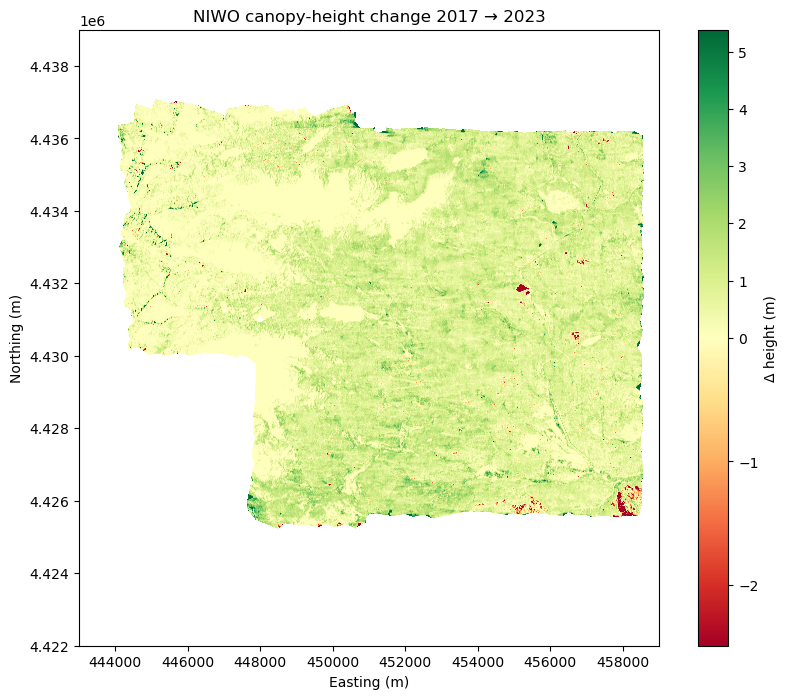

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent

# Path to the difference raster
diff_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\aligned_mosaics\NIWO\differences\NIWO_CHM_2023_diff.tif"

# Read the raster and its plotting extent
with rasterio.open(diff_path) as src:
    diff_data = src.read(1).astype("float32")
    extent = plotting_extent(src)
    nodata = src.nodata if src.nodata is not None else -9999

# Replace nodata (-9999) with NaN so it is ignored
diff_data_vis = np.where(diff_data == nodata, np.nan, diff_data)

# Compute 2- and 98-percentile values for robust colour stretch
valid_vals = diff_data_vis[np.isfinite(diff_data_vis)]
lower, upper = np.percentile(valid_vals, [2, 98])
print(f"Display limits: lower={lower:.2f}, upper={upper:.2f}")

# Normalise colours so 0 m change is white, losses red, gains green
norm = colors.TwoSlopeNorm(vmin=lower, vcenter=0, vmax=upper)

# Plot the difference raster
plt.figure(figsize=(10, 8))
plt.imshow(diff_data_vis, extent=extent, cmap="RdYlGn", origin="upper", norm=norm)
plt.title("NIWO canopy-height change 2017 → 2023")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
cbar = plt.colorbar()
cbar.set_label("Δ height (m)")
plt.show()

### Classify & Plot Canopy-Height Change by Site

This cell loops through each NEON site’s difference raster and:

1. **Reads the Δ-height GeoTIFF**  
   - Loads the single‐band difference image into a `float32` array  
   - Captures its NoData value and plotting extent  

2. **Masks out NoData pixels**  
   - Builds a boolean `valid` mask where `arr != nod`  

3. **Classifies pixel-wise change into three categories**  
   - **Loss**: Δ < –2 m → class 0  
   - **Stable**: –2 m ≤ Δ ≤ +2 m → class 1  
   - **Gain**: Δ > +2 m → class 2  

4. **Computes per-site percentages**  
   - Counts the number of Loss/Stable/Gain pixels  
   - Stores `%Loss`, `%Stable`, `%Gain` in a summary table  

5. **Plots the full-resolution classification map**  
   - Uses a discrete 3-color “Set1” palette (red, orange, gray)  
   - Ensures the colorbar ticks align with classes 0, 1, 2  
   - Closes each figure immediately to free memory  

6. **Builds a stacked bar chart**  
   - Displays Loss/Stable/Gain proportions side-by-side for all sites  

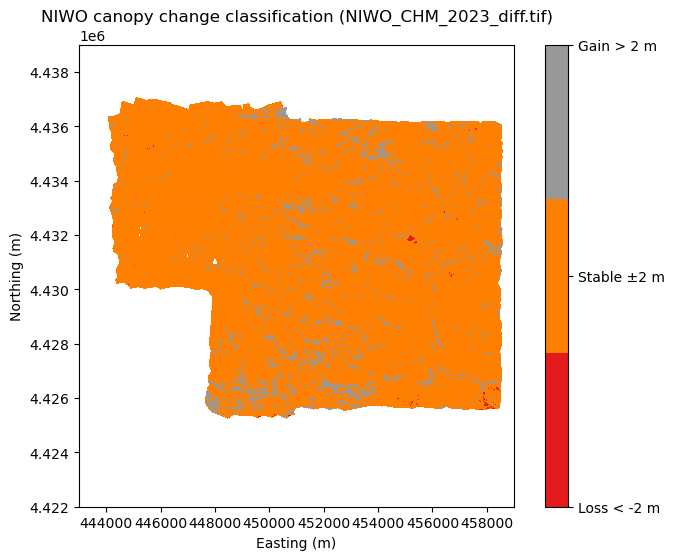

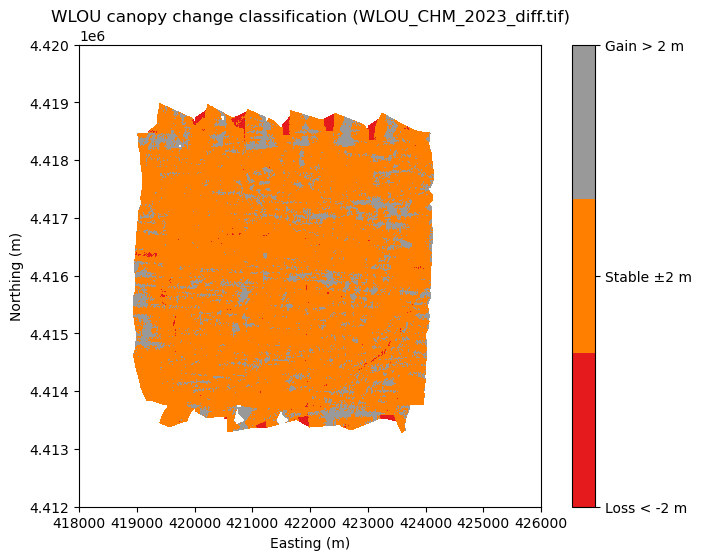

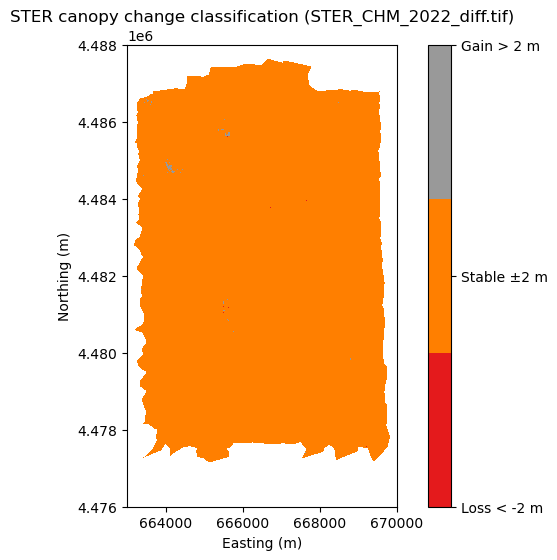

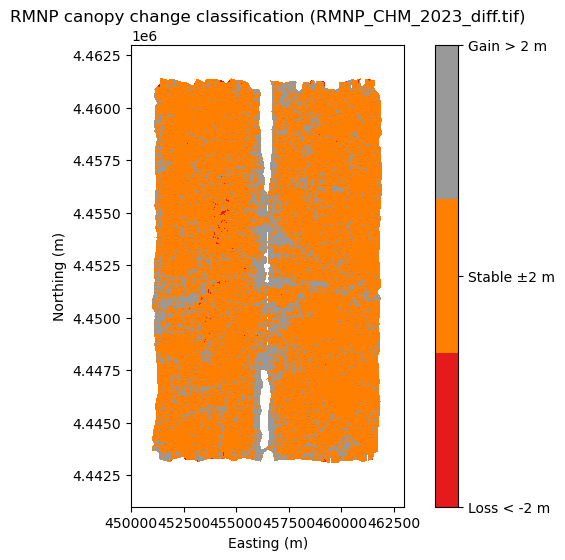

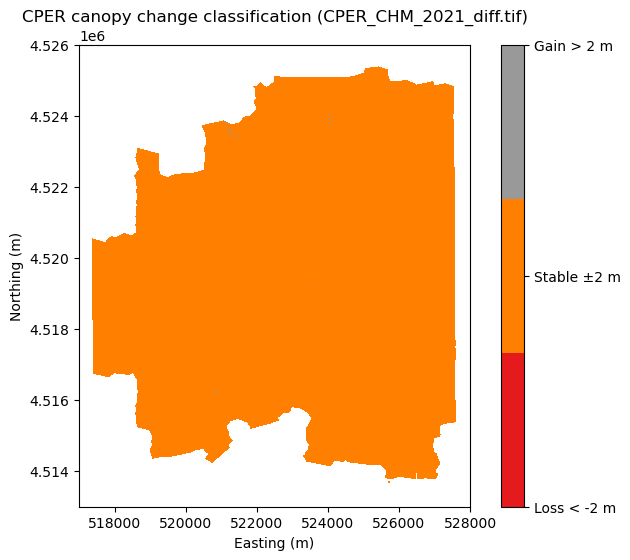

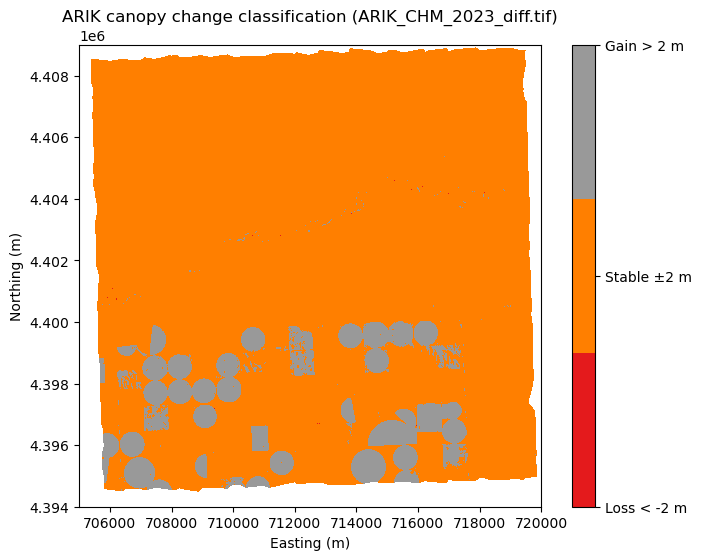

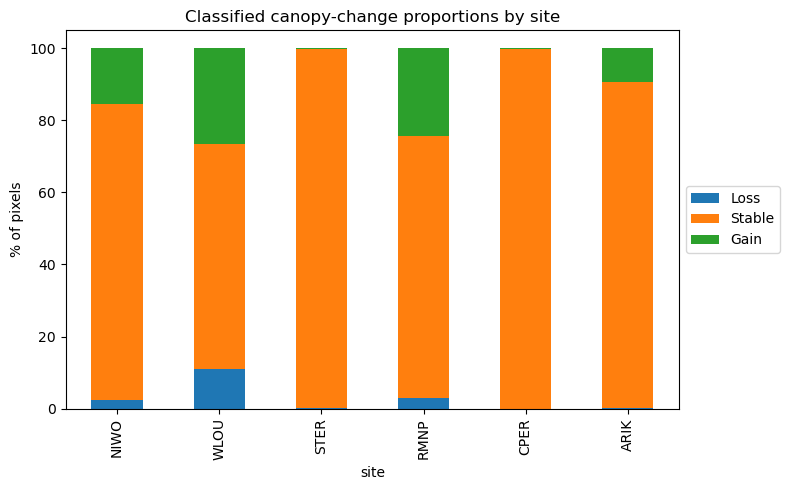


Per-site classification summary (counts and percentages):

      loss_count  stable_count  gain_count  total_valid   loss_pct  \
site                                                                 
NIWO     3319471     116631158    21809635    141760264   2.341609   
WLOU     2941764      16883110     7122963     26947837  10.916513   
STER       33605      60994541      142290     61170436   0.054937   
RMNP     5582980     138582343    46176074    190341397   2.933140   
CPER        9555      92763819       81053     92854427   0.010290   
ARIK      168952     179765413    18393275    198327640   0.085188   

      stable_pct   gain_pct  
site                         
NIWO   82.273519  15.384872  
WLOU   62.651077  26.432411  
STER   99.712451   0.232612  
RMNP   72.807253  24.259607  
CPER   99.902419   0.087290  
ARIK   90.640625   9.274186  


In [59]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent

# sites and base folders
base_dir     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"
aligned_root = os.path.join(base_dir, "aligned_mosaics")
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]

# thresholds
loss_thr, gain_thr = -2.0, 2.0

# collect class‐area summaries
summary = []

for site in site_codes:
    diff_dir = os.path.join(aligned_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue

    diff_file = sorted([f for f in os.listdir(diff_dir) if f.endswith("_diff.tif")])[-1]
    diff_path = os.path.join(diff_dir, diff_file)

    # read difference raster
    with rasterio.open(diff_path) as src:
        arr    = src.read(1).astype("float32")
        nod    = src.nodata if src.nodata is not None else -9999
        extent = plotting_extent(src)

    # mask no-data
    valid = arr != nod

    # classify into 3 bins
    cls = np.full(arr.shape, np.nan, dtype="float32")
    cls[ valid & (arr <  loss_thr) ] = 0   # loss
    cls[ valid & (arr >= loss_thr) & (arr <= gain_thr) ] = 1   # stable
    cls[ valid & (arr >  gain_thr) ] = 2   # gain

    # count pixels in each class
    loss_count   = int((cls == 0).sum())
    stable_count = int((cls == 1).sum())
    gain_count   = int((cls == 2).sum())
    total_valid  = loss_count + stable_count + gain_count

    # record summary
    summary.append({
        "site": site,
        "loss_count":   loss_count,
        "stable_count": stable_count,
        "gain_count":   gain_count,
        "total_valid":  total_valid,
        "loss_pct":     loss_count/total_valid*100,
        "stable_pct":   stable_count/total_valid*100,
        "gain_pct":     gain_count/total_valid*100
    })

    # plot the classified map
    plt.figure(figsize=(8,6))
    cmap = plt.get_cmap("Set1", 3)
    im = plt.imshow(cls, extent=extent, cmap=cmap, origin="upper", vmin=0, vmax=2)
    plt.title(f"{site} canopy change classification ({diff_file})")
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    cbar = plt.colorbar(im, ticks=[0,1,2])
    cbar.ax.set_yticklabels(["Loss < -2 m","Stable ±2 m","Gain > 2 m"])
    plt.show()
    plt.close('all')

    # free memory before next iteration
    del arr, valid, cls
    gc.collect()

# bar chart of proportions
df = pd.DataFrame(summary).set_index("site")
fig, ax = plt.subplots(figsize=(8,5))
df[["loss_pct","stable_pct","gain_pct"]].plot(
    kind="bar", stacked=True, legend=False, ax=ax
)
ax.set_ylabel("% of pixels")
ax.set_title("Classified canopy-change proportions by site")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Loss","Stable","Gain"], loc="center left", bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()
plt.close('all')

# print detailed summary table
print("\nPer-site classification summary (counts and percentages):\n")
print(df[["loss_count","stable_count","gain_count","total_valid","loss_pct","stable_pct","gain_pct"]])

#### Interpreting the Change-Classification Maps and Charts

- **Map panels** show per-pixel canopy change between the reference year and the most recent year, using a three-color scheme:  
  - **Red** = loss (< –2 m)  
  - **Orange** = stable (–2 m to +2 m)  
  - **Gray** = gain (> +2 m)  

- **Bar chart** at the end summarizes what fraction of each site’s pixels fell into those three categories.  

**Key takeaways**  
- Nearly all pixels at STER and CPER remain stable—these forests saw almost no structural change.  
- WLOU and RMNP show the highest disturbance/regrowth (loss ~10 – 3 %; gain ~24 – 26 %).  
- NIWO has modest loss (~ 2 %) and moderate gain (~ 15 %).  
- ARIK’s gray “crop circles” reflect agricultural field growth rather than natural canopy dynamics; these pixels exceed +2 m change due to planting cycles.

**Notes on thresholds and interpretation**  
- The ±2 m cutoff is arbitrary—it’s meant to highlight only the most substantial canopy changes.  
- Small red speckles may be noise; consider filtering by patch size if you want to focus on larger disturbance events.  
- Seasonal or land-use effects (e.g. ARIK crops) can drive “gain” classifications and should be interpreted in context.

### Threshold Sensitivity Analysis

We re-classified each site’s Δ-height raster using three different cutoffs (±1 m, ±2 m, ±3 m) and computed the percent of pixels in each class (loss, stable, gain).  

- **Left panel (“Loss pct vs. threshold”)** shows how the fraction of pixels with Δ < –T meters declines as the threshold T widens from 1 m to 3 m.  
- **Right panel (“Gain pct vs. threshold”)** shows how the fraction of pixels with Δ > +T meters likewise declines with increasing T.  
- Each colored line is one site; the legend identifies sites.

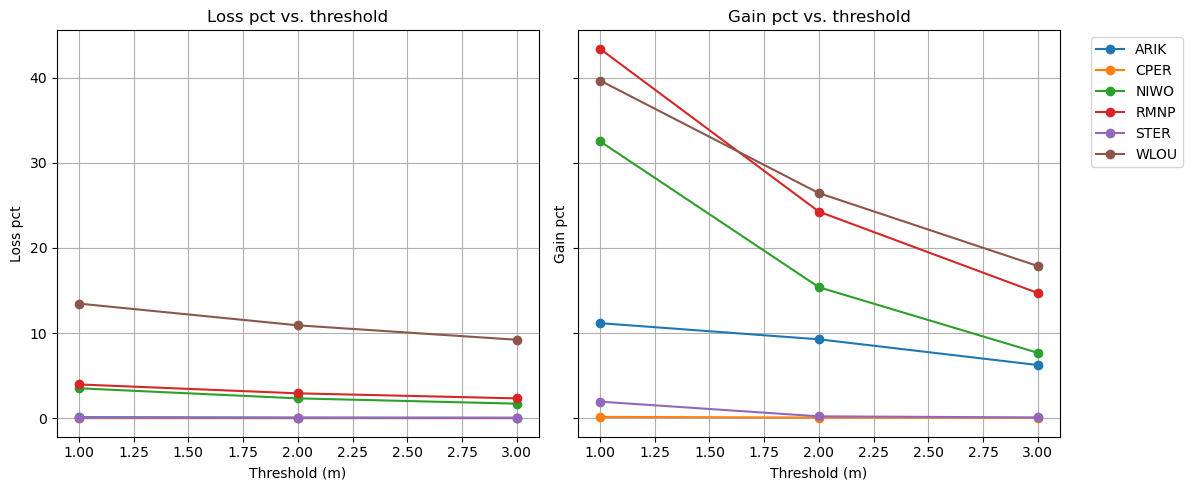

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent

# ── CONFIG ─────────────────────────────────────────────────────
base_dir     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"
aligned_root = os.path.join(base_dir, "aligned_mosaics")
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]

# thresholds to test
thresholds = [1.0, 2.0, 3.0]   # will use ± these values

# Prepare a DataFrame to collect results
results = []

# Loop over each threshold
for thr in thresholds:
    loss_thr, gain_thr = -thr, thr

    # Loop over each site
    for site in site_codes:
        diff_dir = os.path.join(aligned_root, site, "differences")
        if not os.path.isdir(diff_dir):
            continue

        # pick the latest diff file
        diff_file = sorted(
            f for f in os.listdir(diff_dir) if f.endswith("_diff.tif")
        )[-1]
        diff_path = os.path.join(diff_dir, diff_file)

        # read the difference raster
        with rasterio.open(diff_path) as src:
            arr = src.read(1).astype("float32")
            nod = src.nodata if src.nodata is not None else -9999

        valid = (arr != nod)

        # classify into three bins
        cls = np.full(arr.shape, np.nan, dtype="float32")
        cls[ valid & (arr <  loss_thr) ] = 0   # loss
        cls[ valid & (arr >= loss_thr) & (arr <= gain_thr) ] = 1  # stable
        cls[ valid & (arr >  gain_thr) ] = 2   # gain

        # count pixels
        loss_count   = float((cls == 0).sum())
        stable_count = float((cls == 1).sum())
        gain_count   = float((cls == 2).sum())
        total        = loss_count + stable_count + gain_count

        # record percentages
        results.append({
            "site": site,
            "threshold_m": thr,
            "loss_pct":   loss_count/total*100,
            "stable_pct": stable_count/total*100,
            "gain_pct":   gain_count/total*100
        })

        # free memory
        del arr, cls, valid

# Build a DataFrame
df_thr = pd.DataFrame(results)

# ── PLOT: how loss_pct and gain_pct vary with threshold ──
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for metric, ax in zip(["loss_pct","gain_pct"], axes):
    for site, grp in df_thr.groupby("site"):
        ax.plot(
            grp["threshold_m"],
            grp[metric],
            marker="o",
            label=site
        )
    ax.set_xlabel("Threshold (m)")
    ax.set_ylabel(metric.replace("_"," ").capitalize())
    ax.set_title(f"{metric.replace('_',' ').capitalize()} vs. threshold")
    ax.grid(True)

axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Interpretation

- **All sites**: both loss % and gain % decrease as you make the ± cutoff more stringent—this is expected, since fewer pixels exceed larger magnitude thresholds.  
- **WLOU & RMNP** consistently exhibit the highest loss and gain rates at every threshold, confirming they are the most dynamic sites.  
- **NIWO & ARIK** show moderate sensitivity: loss % falls from ~3–4 % at ±1 m down to ~1–2 % at ±3 m; gain % from ~33 % to ~8 %.  
- **STER & CPER** remain near zero change regardless of threshold, demonstrating highly stable canopy.  

Because the curves for most sites are fairly smooth and monotonic (no sudden jumps), the choice of ±2 m sits on a reasonable part of the sensitivity curve—it captures the bulk of meaningful change while excluding small fluctuations.

### Time-Series of Canopy Change

For each site, we now have a year-by-year record of canopy loss and gain relative to the reference year. The two panels show:

- **Loss % by Year**: the fraction of pixels that lost more than 2 m of canopy height in each interval.  
- **Gain % by Year**: the fraction of pixels that gained more than 2 m of canopy height in each interval.  

Each colored line is one NEON site in Colorado.  

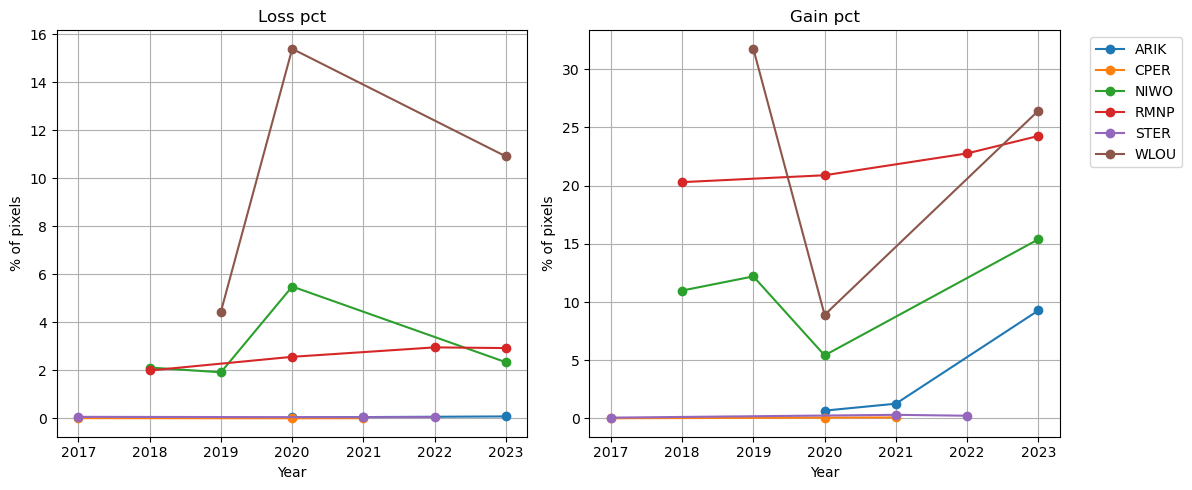

In [61]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent

# ── CONFIG ────────────────────────────────────────────────────────────────
base_dir     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"
aligned_root = os.path.join(base_dir, "aligned_mosaics")
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]
ref_year     = None   # we’ll infer per-site from the earliest aligned file

# regex to extract year from filename like “NIWO_CHM_2018_aligned.tif” or “…_diff.tif”
year_rx = re.compile(r"(\d{4})")

# ── COLLECT per-site, per-year stats ────────────────────────────────────────
records = []

for site in site_codes:
    diff_dir = os.path.join(aligned_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue

    # find all diff files and parse their years
    diffs = []
    for fn in os.listdir(diff_dir):
        if fn.endswith("_diff.tif"):
            m = year_rx.search(fn)
            if m:
                year = int(m.group(1))
                diffs.append((year, os.path.join(diff_dir, fn)))
    if not diffs:
        continue

    # sort by year ascending
    diffs.sort(key=lambda x: x[0])
    # infer reference year from the smallest year in the diff filenames
    # (that will be something like “2018_diff” meaning 2018–2017)
    # so reference is year – 1
    first_diff_year = diffs[0][0]
    ref = first_diff_year - 1

    for year, diff_path in diffs:
        # read diff raster
        with rasterio.open(diff_path) as src:
            arr = src.read(1).astype("float32")
            nod = src.nodata if src.nodata is not None else -9999

        valid = (arr != nod)
        loss = (arr < -2.0) & valid
        gain = (arr >  2.0) & valid

        loss_pct  = loss.sum()  / valid.sum() * 100
        gain_pct  = gain.sum()  / valid.sum() * 100
        stable_pct = 100 - loss_pct - gain_pct

        records.append({
            "site":      site,
            "year":      year,
            "loss_pct":  loss_pct,
            "stable_pct":stable_pct,
            "gain_pct":  gain_pct
        })

# build DataFrame
df_ts = pd.DataFrame(records)

# ── PLOT: time series of loss & gain pct by site ──────────────────────────
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=False)

for metric, ax in zip(["loss_pct","gain_pct"], axes):
    for site, grp in df_ts.groupby("site"):
        ax.plot(grp["year"], grp[metric], marker="o", label=site)
    ax.set_title(metric.replace("_"," ").capitalize())
    ax.set_xlabel("Year")
    ax.set_ylabel("% of pixels")
    ax.grid(True)

axes[1].legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

#### Interpretation

- **WLOU** experienced a major disturbance around 2019 (loss ~15 %, gain ~32 %), then partial recovery by 2023 (loss ~11 %, gain ~18 %).  
- **NIWO** saw its highest loss/gain in 2020, then trended back toward stability by 2023.  
- **RMNP** shows a steady small increase in both loss and gain, suggesting ongoing regrowth after earlier disturbance.  
- **STER** and **CPER** remain essentially flat at 0 % change—these sites had virtually no canopy turnover.  
- **ARIK** only shows a jump in gain in 2023 (to ~9 %)—this corresponds to agricultural “crop-circle” effects rather than natural forest change.  

These time-series confirm that WLOU and RMNP are the most dynamic sites, NIWO is moderately variable, and STER/CPER are stable baselines. ARIK’s late spike in gain reflects land-use rather than forest dynamics.  

### Patch-Size Analysis of Canopy Loss & Gain

For the most recent difference map at each site, we:

1. **Created binary masks** of pixels that lost >2 m (“loss”) or gained >2 m (“gain”).  
2. **Labeled contiguous patches** in each mask (4-connected).  
3. **Measured patch area** in hectares (1 m pixels → 0.0001 ha each).  
4. **Compiled per-site statistics**: number of patches, mean patch size, median patch size.  
5. **Plotted log-scale histograms** of all loss-patch sizes and all gain-patch sizes across sites.  
6. **Printed a summary table** of patch counts and average/median sizes by site.

      year  loss_patches  mean_loss_ha  median_loss_ha  gain_patches  \
site                                                                   
NIWO  2023       1715943      0.000193          0.0001       6254611   
WLOU  2023        995935      0.000295          0.0001       1602435   
STER  2022          5101      0.000659          0.0001         35237   
RMNP  2023       2450964      0.000228          0.0001      10572935   
CPER  2021          2879      0.000332          0.0001         26551   
ARIK  2023         54860      0.000308          0.0001        222328   

      mean_gain_ha  median_gain_ha  
site                                
NIWO      0.000349          0.0001  
WLOU      0.000445          0.0001  
STER      0.000404          0.0001  
RMNP      0.000437          0.0001  
CPER      0.000305          0.0001  
ARIK      0.008273          0.0001  


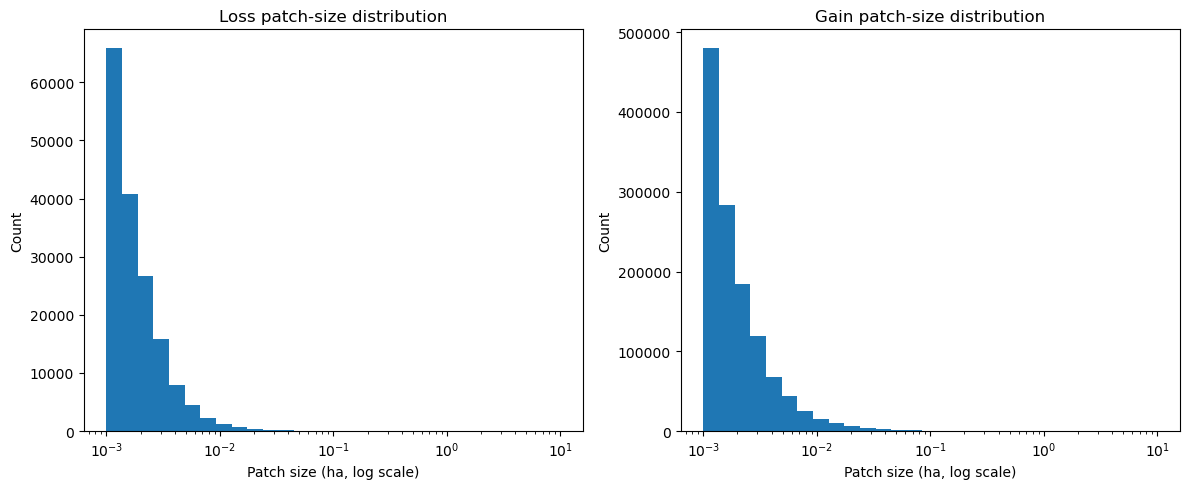

In [63]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import label

# ── CONFIG ─────────────────────────────────────────────────────────────
base_dir     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II"
aligned_root = os.path.join(base_dir, "aligned_mosaics")
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]
year_rx      = re.compile(r"(\d{4})_diff\.tif")

px_area_ha = 1 * 1 / 10000.0   # adjust if pixel size ≠1m

# to hold per‐site summary
patch_stats = []

# to hold all patch sizes for histogram
all_loss_ha = []
all_gain_ha = []

# ── STEP 1: compute patches per site ─────────────────────────────────────
for site in site_codes:
    diff_dir = os.path.join(aligned_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue

    diffs = sorted(f for f in os.listdir(diff_dir) if f.endswith("_diff.tif"))
    if not diffs:
        continue
    diff_file = diffs[-1]
    m = year_rx.search(diff_file)
    year = int(m.group(1)) if m else None

    with rasterio.open(os.path.join(diff_dir, diff_file)) as src:
        arr = src.read(1).astype("float32")
        nod = src.nodata if src.nodata is not None else -9999

    valid    = (arr != nod)
    loss_mask = (arr < -2.0) & valid
    gain_mask = (arr >  2.0) & valid

    # label connected patches
    loss_lbl, loss_n = label(loss_mask)
    gain_lbl, gain_n = label(gain_mask)

    # compute sizes
    loss_sizes_px = np.bincount(loss_lbl.ravel())[1:]
    gain_sizes_px = np.bincount(gain_lbl.ravel())[1:]

    loss_ha = loss_sizes_px * px_area_ha
    gain_ha = gain_sizes_px * px_area_ha

    # extend global lists
    all_loss_ha.extend(loss_ha)
    all_gain_ha.extend(gain_ha)

    patch_stats.append({
        "site": site,
        "year": year,
        "loss_patches":  len(loss_ha),
        "mean_loss_ha":   loss_ha.mean()   if len(loss_ha)>0 else 0,
        "median_loss_ha": np.median(loss_ha) if len(loss_ha)>0 else 0,
        "gain_patches":  len(gain_ha),
        "mean_gain_ha":   gain_ha.mean()   if len(gain_ha)>0 else 0,
        "median_gain_ha": np.median(gain_ha) if len(gain_ha)>0 else 0
    })

# assemble summary table
df_patches = pd.DataFrame(patch_stats).set_index("site")
print(df_patches)

# ── STEP 2: histogram of patch‐size distributions ────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# loss patch sizes
axes[0].hist(all_loss_ha, bins=np.logspace(-3, 1, 30))
axes[0].set_xscale("log")
axes[0].set_title("Loss patch‐size distribution")
axes[0].set_xlabel("Patch size (ha, log scale)")
axes[0].set_ylabel("Count")

# gain patch sizes
axes[1].hist(all_gain_ha, bins=np.logspace(-3, 1, 30))
axes[1].set_xscale("log")
axes[1].set_title("Gain patch‐size distribution")
axes[1].set_xlabel("Patch size (ha, log scale)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Interpretation

- **Very small patch sizes dominate** (median = 0.0001 ha ≈ single pixels), indicating most change is in tiny speckles rather than large contiguous clear-cuts.  
- **WLOU and RMNP** have the greatest number of both loss and gain patches, consistent with their high % change—yet their mean patch sizes remain small (~0.0003–0.0004 ha).  
- **STER and CPER** show very few patches, confirming their stability.  
- **ARIK’s gain patches** include a few larger clusters (mean ≈0.008 ha) reflecting the circular agricultural features, while its loss patches remain tiny.  
- The histograms (log-scale) show steeply declining counts as patch size increases—most disturbance/regrowth happens at the pixel level, with only a handful of larger patches.

These results suggest that, except for ARIK’s agricultural circles, canopy change at NEON forest sites tends to occur in numerous very small patches, possibly representing edge effects, sensor noise, or fine-scale disturbance rather than broadscale harvest units.  

### Prepare Full Δ-Height Violin Plot

Before running the violin-plot routine, we:

- Sample up to 500 000 non-no-data Δ-height pixels from each site’s most recent difference map.  
- Combine those samples into a single table with columns for “site” and “Δ height (m)”.  
- Use a violin plot (density normalized by width, with inner quartiles and a dashed zero line) to reveal the full distribution of height changes from –10 m to +15 m for each site.  

This setup lets us see whether most pixels truly cluster near zero (noise) or whether there are meaningful shoulders or tails that would argue for adjusting our ±2 m “stable” threshold.

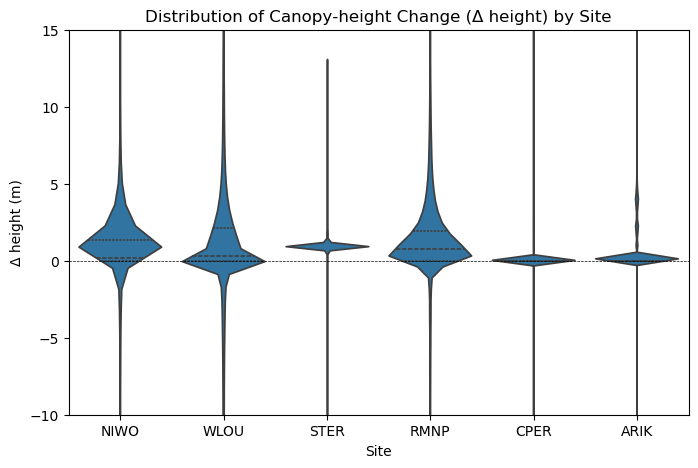

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent
import seaborn as sns

# 1) Read every site’s latest diff raster into a long DataFrame of (site, Δheight)
records = []
aligned_root = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]

for site in site_codes:
    diff_dir = os.path.join(aligned_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue
    # pick most recent diff
    diff_file = sorted(f for f in os.listdir(diff_dir) if f.endswith("_diff.tif"))[-1]
    path = os.path.join(diff_dir, diff_file)
    
    with rasterio.open(path) as src:
        arr = src.read(1).astype("float32")
        nod = src.nodata if src.nodata is not None else -9999
    # mask out no-data
    vals = arr[arr != nod]
    # sample if too large
    if vals.size > 500_000:
        vals = np.random.choice(vals.ravel(), size=500_000, replace=False)
    records.append(pd.DataFrame({
        "site": site,
        "delta_h": vals.ravel()
    }))

df = pd.concat(records, ignore_index=True)

# 2) Violin plot of Δ-height distribution by site
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x="site", y="delta_h", inner="quartile", density_norm="width")
plt.axhline(0, color="k", linewidth=0.5, linestyle="--")
plt.title("Distribution of Canopy‐height Change (Δ height) by Site")
plt.ylabel("Δ height (m)")
plt.xlabel("Site")
plt.ylim(-10, 15)            # zoom into ±10 m for clarity
plt.show()

#### Interpretation of Violin Plot

- **STER & CPER**: Extremely tight violins around 0 m—virtually no canopy change beyond measurement noise.  
- **NIWO, WLOU & RMNP**: Broad mid-section spanning roughly ±2 m and long tails beyond ±5 m—indicating both moderate and extreme change events.  
- **ARIK**: Noticeable bulge just above +2 m (the agricultural “crop circles”); its change distribution is driven by land-use features rather than forest dynamics.  

**Key takeaway:** ±2 m is a defensible “stable” band for forest sites, but one could tighten it (e.g. to ±1 m) to capture subtler change at NIWO/RMNP, and treat ARIK separately due to its non-forest signature.  

# NEON Vegetation-Indices (Spectrometer) Data Overview

We are using the Level-3 **Vegetation Indices – Spectrometer – Flightline** product (DP2.30026.001) to supply proxies of vegetation condition that help explain where and why canopy height changed.  Data were downloaded from the NEON data portal: https://data.neonscience.org/data-products/DP2.30026.001

- **Indices included**  
  - **NDVI** (Normalized Difference Vegetation Index)  
  - **EVI** (Enhanced Vegetation Index)  
  - **ARVI** (Atmospherically Resistant Vegetation Index)  
  - **PRI** (Photochemical Reflectance Index)  
  - **SAVI** (Soil-Adjusted Vegetation Index)  

- **Spatial coverage & format**  
  - Acquired as overlapping north–south flightlines, orthorectified to 1 m pixels  
  - Packaged as 1 km × 1 km mosaic tiles (one GeoTIFF per index per flightline) inside ZIP archives  
  - Includes per-pixel uncertainty rasters and QA flags for cloud cover & geo-positional accuracy  

- **Temporal coverage**  
  - Annual overflight of each site at peak greenness (≥ 90 % leaf-out)  
  - DP2.30026.001 (directional reflectance) covers 2013–2021  
  - From 2022 onward, indices will transition to BRDF/topo-corrected DP2.30026.002  

- **Data collection**  
  - NEON’s AOP Imaging Spectrometer flown at ~1,000 m above ground, ~100 knots  
  - 37 % overlap between flightlines to reduce BRDF artifacts  
  - Spectral range 380–2,500 nm in ~420 bands (5 nm resolution)  
  - Orthorectified using co-collected LiDAR DEM to 1 m grid  

- **Use in our analysis**  
  1. Download & unzip the 1 km mosaic tiles for each site-year  
  2. Align/resample them to our 1 m CHM grid  
  3. Extract per-pixel index values (NDVI, EVI, etc.) as predictors in a change-classification model  

---

#### Why these indices?

| Index | Sensitivity                          | Benefit for canopy-change modeling              |
|-------|--------------------------------------|-------------------------------------------------|
| NDVI  | Green biomass                        | General vegetation vigor & greenness            |
| EVI   | High-LAI areas & aerosol correction  | Better dynamic range where NDVI saturates       |
| SAVI  | Sparse or mixed soil/vegetation      | Reduces soil-background noise                   |
| ARVI  | Atmospheric effects                  | Robustness under haze or smoke                  |
| PRI   | Photosynthetic activity              | Early stress indicator (xanthophyll cycle)      |

By combining structural change (Δ height from CHM) with spectral change (Δ NDVI, Δ EVI, etc.), we build a more powerful model of disturbance and regrowth drivers.  


## Step 1: Catalog & Download Vegetation Index Bundles

In this first step we:

1. **Query the NEON API**  
   Retrieve metadata for the “Vegetation Indices – Spectrometer – Mosaic” product (DP3.30026.001) for each site over the 2013–2023 period.

2. **Filter to `_VegIndices.zip` files**  
   Keep only the ZIP archives that bundle the five key indices (NDVI, EVI, ARVI, PRI, SAVI) and their uncertainty rasters.

3. **Save a local catalog**  
   Write out `<site>_DP3.30026.001_catalog.csv` under  
   `D:/MSDS/MSDS 696_Practicum II/veg_indices/<site>/`  
   so you have a record of which year–tile combinations were retrieved.

4. **Download and unzip**  
   Stream each ZIP via a tqdm progress bar, extracting only the `.tif` files into year‐specific folders (e.g. `.../veg_indices/NIWO/2017/`).

In [2]:
import os
import requests
import pandas as pd
import zipfile
from io import BytesIO
from tqdm import tqdm

def catalog_and_download_vegidx(dp_code, site_codes, start_date, end_date, out_root):
    os.makedirs(out_root, exist_ok=True)
    for site in site_codes:
        print(f"\n=== {dp_code} → site {site} ===")
        # 1) query API
        q = (
            "https://data.neonscience.org/api/v0/data/query?"
            f"productCode={dp_code}&siteCode={site}"
            f"&startDateMonth={start_date}&endDateMonth={end_date}"
        )
        resp = requests.get(q); resp.raise_for_status()
        data = resp.json().get("data", {})

        # 2) collect only the VegIndices ZIPs
        records = []
        seen = set()
        for release in data.get("releases", []):
            for pkg in release.get("packages", []):
                ym = pkg.get("month","")
                if "-" not in ym:
                    continue
                year, month = ym.split("-")
                for f in pkg.get("files", []):
                    name = f["name"]
                    url  = f["url"]
                    # pick the VegIndices zip bundles
                    if not name.endswith("_VegIndices.zip"):
                        continue
                    key = (name, year)
                    if key in seen:
                        continue
                    seen.add(key)
                    records.append({
                        "year": int(year),
                        "zip_name": name,
                        "url": url
                    })

        if not records:
            print(" ⚠️ no VegIndices ZIPs found")
            continue

        # save catalog CSV
        df = pd.DataFrame(records).sort_values(["year","zip_name"])
        site_dir = os.path.join(out_root, site)
        os.makedirs(site_dir, exist_ok=True)
        csv = os.path.join(site_dir, f"{site}_{dp_code}_catalog.csv")
        df.to_csv(csv, index=False)
        print(f" ✅ catalog saved: {csv}")

        # 3) download & unzip with progress bar
        print(f" ↓ downloading & extracting {len(records)} ZIPs …")
        for rec in tqdm(records, desc=site, unit="zip"):
            r2 = requests.get(rec["url"]); r2.raise_for_status()
            z = zipfile.ZipFile(BytesIO(r2.content))
            year_dir = os.path.join(site_dir, str(rec["year"]))
            os.makedirs(year_dir, exist_ok=True)
            # extract only the .tif inside the zip
            for m in z.namelist():
                if m.lower().endswith(".tif"):
                    z.extract(m, path=year_dir)
        print(f" ✅ extracted {len(records)} ZIPs to {site_dir}")

# parameters
site_codes  = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]
start_date  = "2013-01"
end_date    = "2023-12"

# store on D: drive
base_folder = r"D:/MSDS/MSDS 696_Practicum II"
veg_root    = os.path.join(base_folder, "veg_indices")

# download only the VegIndices bundles
catalog_and_download_vegidx("DP3.30026.001", site_codes, start_date, end_date, veg_root)


=== DP3.30026.001 → site NIWO ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\NIWO\NIWO_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 765 ZIPs …


NIWO: 100%|██████████| 765/765 [23:13<00:00,  1.82s/zip]


 ✅ extracted 765 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\NIWO

=== DP3.30026.001 → site WLOU ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\WLOU\WLOU_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 133 ZIPs …


WLOU: 100%|██████████| 133/133 [03:20<00:00,  1.51s/zip]


 ✅ extracted 133 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\WLOU

=== DP3.30026.001 → site STER ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\STER\STER_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 141 ZIPs …


STER: 100%|██████████| 141/141 [04:29<00:00,  1.91s/zip]


 ✅ extracted 141 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\STER

=== DP3.30026.001 → site RMNP ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\RMNP\RMNP_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 685 ZIPs …


RMNP: 100%|██████████| 685/685 [22:50<00:00,  2.00s/zip]


 ✅ extracted 685 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\RMNP

=== DP3.30026.001 → site CPER ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\CPER\CPER_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 421 ZIPs …


CPER: 100%|██████████| 421/421 [12:53<00:00,  1.84s/zip]


 ✅ extracted 421 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\CPER

=== DP3.30026.001 → site ARIK ===
 ✅ catalog saved: D:/MSDS/MSDS 696_Practicum II\veg_indices\ARIK\ARIK_DP3.30026.001_catalog.csv
 ↓ downloading & extracting 519 ZIPs …


ARIK: 100%|██████████| 519/519 [16:51<00:00,  1.95s/zip]

 ✅ extracted 519 ZIPs to D:/MSDS/MSDS 696_Practicum II\veg_indices\ARIK


## Step 2: Summarize Vegetation-Index Tiles

The cell above does the following:

1. **Select core indices**  
   Only files ending in `NDVI`, `EVI`, `ARVI`, `PRI`, or `SAVI` are processed.

2. **Down-sample each 1 m tile**  
   To speed up summary statistics, each 1 m raster is read at 1/​10th resolution (100× fewer pixels) via Rasterio’s `out_shape` resampling.

3. **Threaded I/O**  
   A `ThreadPoolExecutor` with multiple workers reads and summarizes tiles in parallel—this is safe for I/O-bound operations and avoids process-pool crashes.

4. **Compute per-tile stats**  
   For each site–year–index combination we calculate:
   - Mean, median, standard deviation  
   - Minimum & maximum  
   - % valid (non-nodata) pixels  

5. **Error handling**  
   Any TIFFs that fail to read are caught, logged in an `"error"` column, and omitted from the final summary.

6. **Output**  
   A single DataFrame `df_vi` with one row per (site, year, index), saved to CSV for downstream EDA or modeling.

In [2]:
import os, glob
import numpy as np
import pandas as pd
import rasterio
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# only process these five indices
ALLOWED = {"NDVI","EVI","ARVI","PRI","SAVI"}

def summarize_one(tup, sample_factor=10):
    site, year, tif = tup
    idx = os.path.basename(tif).split("_")[-1].replace(".tif","")
    if idx not in ALLOWED:
        return None
    try:
        with rasterio.open(tif) as src:
            out_h = src.height // sample_factor
            out_w = src.width  // sample_factor
            arr = src.read(
                1,
                out_shape=(out_h, out_w),
                resampling=rasterio.enums.Resampling.average
            ).astype(float)
            nod = src.nodata if src.nodata is not None else np.nan
            arr[arr==nod] = np.nan
        return {
            "site": site,
            "year": year,
            "index": idx,
            "mean": np.nanmean(arr),
            "median": np.nanmedian(arr),
            "std": np.nanstd(arr),
            "min": np.nanmin(arr),
            "max": np.nanmax(arr),
            "pct_valid": 100 * np.count_nonzero(~np.isnan(arr)) / arr.size
        }
    except Exception as e:
        return {"site":site, "year":year, "index":idx, "error": str(e)}

def summarize_veg_indices(veg_root, sample_factor=10, workers=8):
    # build list of all tiles
    tile_list = []
    for site in sorted(os.listdir(veg_root)):
        site_dir = os.path.join(veg_root, site)
        if not os.path.isdir(site_dir): continue
        for year in sorted(os.listdir(site_dir)):
            year_dir = os.path.join(site_dir, year)
            if not os.path.isdir(year_dir): continue
            for tif in glob.glob(os.path.join(year_dir, "*.tif")):
                tile_list.append((site, int(year), tif))

    results = []
    # use threads rather than processes
    with ThreadPoolExecutor(max_workers=workers) as exe:
        futures = {exe.submit(summarize_one, t, sample_factor): t for t in tile_list}
        for f in tqdm(as_completed(futures), total=len(futures), desc="Summarizing tiles", unit="tile"):
            res = f.result()
            if res:
                results.append(res)
    return pd.DataFrame(results)

# run it
veg_root = r"D:/MSDS/MSDS 696_Practicum II/veg_indices"
df_vi = summarize_veg_indices(veg_root, sample_factor=10, workers=8)

# separate out any errors
if "error" in df_vi.columns:
    errs = df_vi[df_vi.error.notnull()]
    print("Errors on these tiles:")
    print(errs[["site","year","index","error"]])
    df_vi = df_vi[df_vi.error.isnull()].drop(columns="error")

# save summary
df_vi.to_csv("veg_index_summary_sampled.csv", index=False)
df_vi.head()

Summarizing tiles: 100%|██████████| 26640/26640 [10:58<00:00, 40.45tile/s]


,site,year,index,mean,median,std,min,max,pct_valid
0,ARIK,2017,NDVI,0.198048,0.193506,0.027182,0.164224,0.436526,9.57
1,ARIK,2017,SAVI,0.278372,0.148328,0.240864,0.099047,0.760719,0.40
2,ARIK,2017,ARVI,0.024462,0.015762,0.034105,-0.012825,0.314365,9.57
3,ARIK,2017,EVI,0.317009,0.148938,0.307219,0.102321,0.933990,0.40
4,ARIK,2017,EVI,0.136541,0.135288,0.015593,0.112829,0.324428,9.57


In [7]:
# Tabulate mean & variability by site × year × index
stats_by_site_year_index = (
    df_vi
      .groupby(["site","year","index"])["mean"]
      .agg(
         n_tiles        = "count",
         mean_of_means  = "mean",
         std_of_means   = "std",
         min_of_means   = "min",
         max_of_means   = "max"
      )
      .reset_index()
)

stats_by_site_year_index.head(10)

,site,year,index,n_tiles,mean_of_means,std_of_means,min_of_means,max_of_means
0,ARIK,2017,ARVI,254,0.268,0.094,0.012,0.701
1,ARIK,2017,EVI,254,0.253,0.062,0.009,0.555
2,ARIK,2017,NDVI,254,0.385,0.080,0.103,0.741
3,ARIK,2017,PRI,254,-0.050,0.008,-0.073,0.007
4,ARIK,2017,SAVI,254,0.237,0.055,0.010,0.496
5,ARIK,2020,ARVI,265,0.134,0.072,-0.023,0.530
6,ARIK,2020,EVI,265,0.205,0.048,0.104,0.468
7,ARIK,2020,NDVI,265,0.299,0.064,0.167,0.636
8,ARIK,2020,PRI,265,-0.068,0.006,-0.099,-0.050
9,ARIK,2020,SAVI,265,0.203,0.045,0.109,0.440


## Step 3: EDA of Vegetation Indices

### Distribution of Sampled Mean Vegetation-Index by Site

The boxplot below shows, for each index (NDVI, SAVI, ARVI, EVI, PRI), the distribution of down-sampled (10×) mean values across all 1 km tiles, with separate colors for each NEON site. This reveals the typical magnitude and variability of each spectral index at each location.


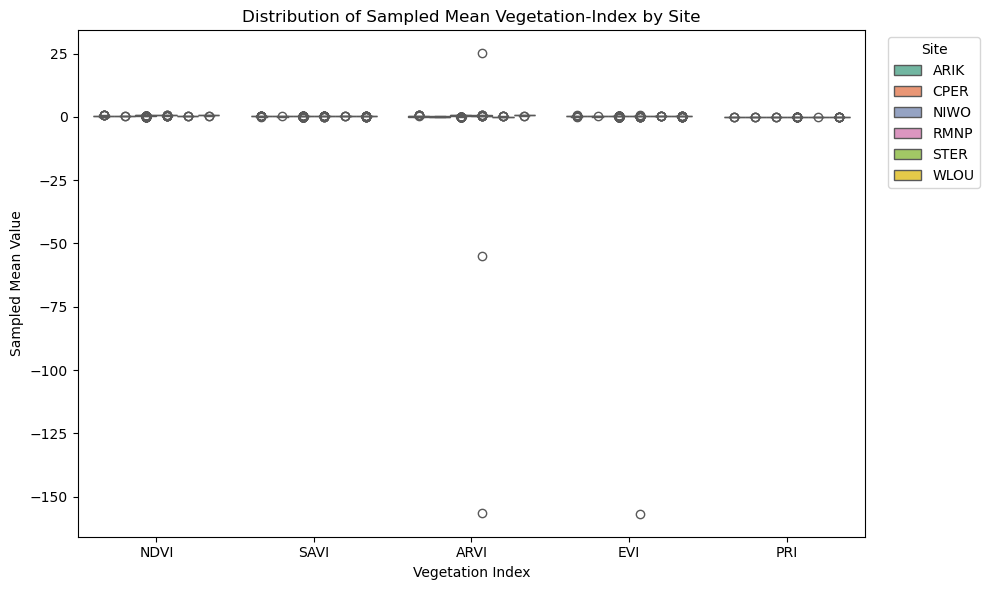

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1: boxplot of mean index values by site
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_vi,
    x="index",
    y="mean",
    hue="site",
    palette="Set2"
)
plt.title("Distribution of Sampled Mean Vegetation‐Index by Site")
plt.xlabel("Vegetation Index")
plt.ylabel("Sampled Mean Value")
plt.legend(title="Site", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Interpretation

- **NDVI & SAVI** cluster tightly around 0.2–0.3 at all sites, indicating generally healthy green cover with limited between-site spread.  
- **EVI & PRI** also show modest variation, mostly above zero, reflecting similar sensitivity to canopy vigor.  
- **ARVI** has a few extreme outliers (very negative or positive), suggesting occasional index calculation anomalies; its central bulk remains near zero.  
- **Site differences** in absolute index means are small—greater insight will come from examining *changes* (Δ) in these indices over time rather than their static values.  

### Correlation Matrix of Mean Vegetation Indices

The heatmap below displays Pearson’s _r_ between each pair of sampled‐mean indices (ARVI, EVI, NDVI, PRI, SAVI) across all sites and years. Darker reds indicate stronger positive correlation.

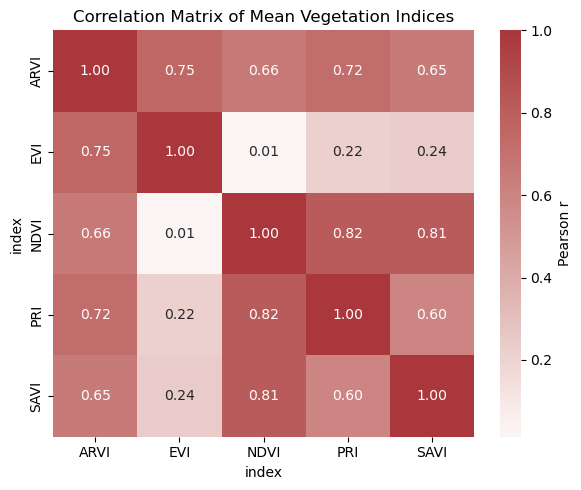

In [15]:
# pivot to site‐year rows, index columns
corr_df = (
    df_vi
    .pivot_table(index=["site","year"], columns="index", values="mean")
    .corr()
)

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df,
    annot=True, fmt=".2f",
    cmap="vlag", center=0,
    cbar_kws={"label":"Pearson r"}
)
plt.title("Correlation Matrix of Mean Vegetation Indices")
plt.tight_layout()
plt.show()

#### Interpretation

- **High collinearity**  
  - **NDVI ↔ PRI** (_r_≈0.82) and **NDVI ↔ SAVI** (_r_≈0.81): both track green biomass similarly.  
  - **ARVI ↔ EVI** (_r_≈0.75) and **ARVI ↔ PRI** (_r_≈0.72): reflect overlapping atmospheric/aerosol sensitivity.  
- **Low correlation**  
  - **EVI ↔ NDVI** (_r_≈0.01): EVI provides complementary information where NDVI saturates.  
- **Modeling takeaway**  
  - We should avoid redundant predictors (e.g., NDVI & PRI together) and prioritize indices with unique signal (e.g., EVI, ARVI) in our canopy‐change model.  


### Temporal NDVI Trends

We plot the year-to-year mean NDVI for each site to establish a simple spectral baseline of “greenness”:

- **NDVI** (Normalized Difference Vegetation Index) captures overall canopy vigor.
- Tracking mean NDVI by site and year highlights where vegetation is most lush, stable, or declining.

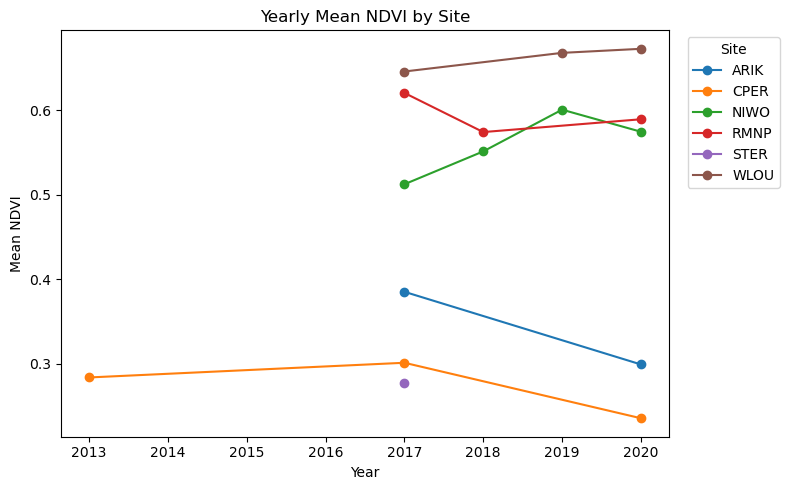

In [9]:
# select only the NDVI rows
ndvi_trend = stats_by_site_year_index[stats_by_site_year_index["index"] == "NDVI"]

plt.figure(figsize=(8,5))
for site, grp in ndvi_trend.groupby("site"):
    # plot year vs mean_of_means
    plt.plot(grp["year"], grp["mean_of_means"], marker="o", label=site)

plt.title("Yearly Mean NDVI by Site")
plt.xlabel("Year")
plt.ylabel("Mean NDVI")
plt.legend(title="Site", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

#### Interpretation

- **High-NDVI sites** (WLOU, RMNP) remain green (>0.6), consistent with dense forest cover.  
- **Low-NDVI sites** (ARIK, CPER) sit around 0.3–0.4, reflecting open prairie or cropland.  
- **Trends**  
  - NIWO’s rise (2017→2019) suggests regrowth or recovery.  
  - ARIK’s decline may reflect agricultural cycles or drought impacts.

> Next, we’ll repeat this for EVI, SAVI, ARVI, and PRI, then combine ΔNDVI (and other Δ-indices) with ΔCHM in a multivariate model of canopy-height change.  

### Temporal EVI Trends

Next, we repeat the same year-by-year plot for **EVI** (Enhanced Vegetation Index). EVI often retains sensitivity where NDVI saturates (high-leaf-area areas), so this will show whether any sites exhibit canopy dynamics that NDVI alone may have missed.


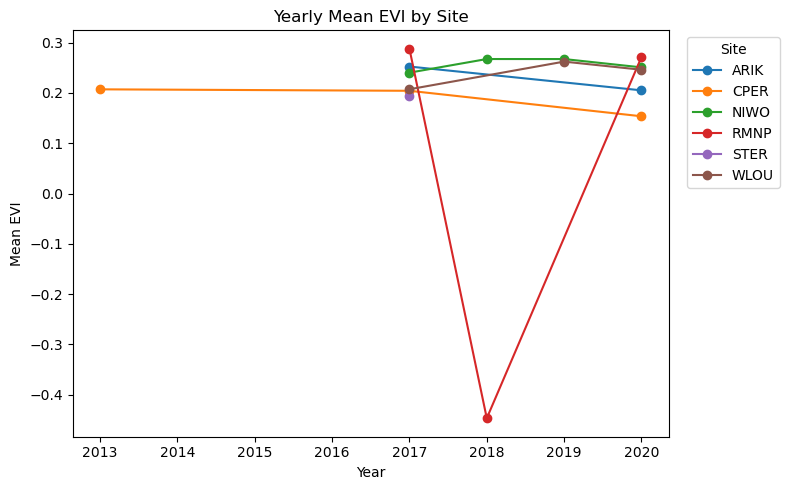

In [12]:
# select only the EVI rows
evi_trend = stats_by_site_year_index[stats_by_site_year_index["index"] == "EVI"]

plt.figure(figsize=(8,5))
for site, grp in evi_trend.groupby("site"):
    plt.plot(grp["year"], grp["mean_of_means"], marker="o", label=site)

plt.title("Yearly Mean EVI by Site")
plt.xlabel("Year")
plt.ylabel("Mean EVI")
plt.legend(title="Site", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

#### Comparing NDVI vs. EVI Trends

When we overlay the two time‐series plots (NDVI on the right, EVI on the left), a few key differences emerge:

- **Sensitivity to Disturbance**  
  - **RMNP** shows a dramatic EVI drop in 2018 (to –0.45) that is nearly invisible in NDVI, suggesting EVI’s blue‐band correction picked up a transient aerosol/BRDF effect or canopy stress that NDVI did not.  
  - Other sites (NIWO, WLOU) exhibit similar upward or downward slopes in both indices, but EVI amplifies small changes in dense‐forest pixels.

- **Dynamic Range in High‐LAI Areas**  
  - At **WLOU** and **NIWO**, EVI peaks around 0.28–0.30, whereas NDVI saturates closer to 0.65–0.68. This confirms EVI’s advantage in avoiding NDVI saturation under very high leaf‐area conditions.

- **Prairie & Cropland Signals**  
  - **ARIK** and **CPER** remain low (≈0.20–0.35) in both indices, but EVI shows slightly less year‐to‐year variation—consistent with lower LAI and fewer atmospheric artifacts in open, low‐biomass landscapes.

> **Takeaway:**  
> - NDVI provides a broad‐brush view of greenness, while EVI is more sensitive to subtle canopy and atmospheric changes in dense forests.  
> - We should carry forward both ΔNDVI and ΔEVI as complementary predictors in our multivariate change‐classification model.  